##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Autoencoder 소개

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/autoencoder"><img src="https://www.tensorflow.org/images/tf_logo_32px.png"> TensorFlow.org에서 보기</a> </td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/tutorials/generative/autoencoder.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행하기</a> </td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/generative/autoencoder.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 소그 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/tutorials/generative/autoencoder.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운론드하기</a></td>
</table>

이 튜토리얼에서는 3가지 예(기본 사항, 이미지 노이즈 제거 및 이상 감지)를 통해 autoencoder를 소개합니다.

autoencoder는 입력을 출력에 복사하도록 훈련된 특수한 유형의 신경망입니다. 예를 들어, 손으로 쓴 숫자의 이미지가 주어지면 autoencoder는 먼저 이미지를 더 낮은 차원의 잠재 표현으로 인코딩한 다음 잠재 표현을 다시 이미지로 디코딩합니다. autoencoder는 재구성 오류를 최소화하면서 데이터를 압축하는 방법을 학습합니다.

autoencoder에 대해 자세히 알아보려면 Ian Goodfellow, Yoshua Bengio 및 Aaron Courville의 [딥 러닝](https://www.deeplearningbook.org/)에서 14장을 읽어보세요.

## TensorFlow 및 기타 라이브러리 가져오기

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

2022-12-14 23:24:00.482364: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 23:24:00.482499: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 23:24:00.482510: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## 데이터세트 로드하기

시작하려면 Fashon MNIST 데이터세트를 사용하여 기본 autoencoder를 훈련합니다. 이 데이터세트의 각 이미지는 28x28 픽셀입니다. 

In [3]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


## 첫 번째 예: 기본 autoencoder

![기본 오토 인코더 결과](images/intro_autoencoder_result.png)

두 개의 Dense 레이어로 autoencoder를 정의합니다. 이미지를 64차원 잠재 벡터로 압축하는 `encoder`와 잠재 공간에서 원본 이미지를 재구성하는 `decoder`입니다.

모델을 정의하려면 [Keras Model Subclassing API](https://www.tensorflow.org/guide/keras/custom_layers_and_models)를 사용하세요.


In [4]:
latent_dim = 64 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
autoencoder = Autoencoder(latent_dim) 

In [5]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

`x_train`을 입력과 대상으로 사용하여 모델을 훈련합니다. `encoder`는 데이터세트를 784차원에서 잠재 공간으로 압축하는 방법을 배우고, `decoder`는 원본 이미지를 재구성하는 방법을 배웁니다. .

In [6]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10


   1/1875 [..............................] - ETA: 42:40 - loss: 0.1809

  26/1875 [..............................] - ETA: 3s - loss: 0.1313   

  52/1875 [..............................] - ETA: 3s - loss: 0.1036

  78/1875 [>.............................] - ETA: 3s - loss: 0.0892

 105/1875 [>.............................] - ETA: 3s - loss: 0.0797

 131/1875 [=>............................] - ETA: 3s - loss: 0.0729

 157/1875 [=>............................] - ETA: 3s - loss: 0.0680

 184/1875 [=>............................] - ETA: 3s - loss: 0.0640

 210/1875 [==>...........................] - ETA: 3s - loss: 0.0606

 237/1875 [==>...........................] - ETA: 3s - loss: 0.0578

 263/1875 [===>..........................] - ETA: 3s - loss: 0.0554

 289/1875 [===>..........................] - ETA: 3s - loss: 0.0534

 315/1875 [====>.........................] - ETA: 3s - loss: 0.0516

 341/1875 [====>.........................] - ETA: 2s - loss: 0.0499

 367/1875 [====>.........................] - ETA: 2s - loss: 0.0484

 393/1875 [=====>........................] - ETA: 2s - loss: 0.0471

 419/1875 [=====>........................] - ETA: 2s - loss: 0.0458

 446/1875 [======>.......................] - ETA: 2s - loss: 0.0446

 472/1875 [======>.......................] - ETA: 2s - loss: 0.0436

 499/1875 [======>.......................] - ETA: 2s - loss: 0.0426

 526/1875 [=======>......................] - ETA: 2s - loss: 0.0417

 553/1875 [=======>......................] - ETA: 2s - loss: 0.0408

 579/1875 [========>.....................] - ETA: 2s - loss: 0.0401

 606/1875 [========>.....................] - ETA: 2s - loss: 0.0393

 632/1875 [=========>....................] - ETA: 2s - loss: 0.0387

 658/1875 [=========>....................] - ETA: 2s - loss: 0.0380

 685/1875 [=========>....................] - ETA: 2s - loss: 0.0374

 711/1875 [==========>...................] - ETA: 2s - loss: 0.0368

 737/1875 [==========>...................] - ETA: 2s - loss: 0.0363

 763/1875 [===========>..................] - ETA: 2s - loss: 0.0358

 789/1875 [===========>..................] - ETA: 2s - loss: 0.0353

 815/1875 [============>.................] - ETA: 2s - loss: 0.0348

 841/1875 [============>.................] - ETA: 2s - loss: 0.0343

 867/1875 [============>.................] - ETA: 1s - loss: 0.0338

 893/1875 [=============>................] - ETA: 1s - loss: 0.0334

 920/1875 [=============>................] - ETA: 1s - loss: 0.0330

 946/1875 [==============>...............] - ETA: 1s - loss: 0.0326

 972/1875 [==============>...............] - ETA: 1s - loss: 0.0322

 999/1875 [==============>...............] - ETA: 1s - loss: 0.0318

1024/1875 [===============>..............] - ETA: 1s - loss: 0.0315

1051/1875 [===============>..............] - ETA: 1s - loss: 0.0311

1078/1875 [================>.............] - ETA: 1s - loss: 0.0308

1104/1875 [================>.............] - ETA: 1s - loss: 0.0304

1130/1875 [=================>............] - ETA: 1s - loss: 0.0301

1156/1875 [=================>............] - ETA: 1s - loss: 0.0298

1182/1875 [=================>............] - ETA: 1s - loss: 0.0295

1209/1875 [==================>...........] - ETA: 1s - loss: 0.0292

1234/1875 [==================>...........] - ETA: 1s - loss: 0.0290

1259/1875 [===================>..........] - ETA: 1s - loss: 0.0287

1285/1875 [===================>..........] - ETA: 1s - loss: 0.0284

1311/1875 [===================>..........] - ETA: 1s - loss: 0.0282

1337/1875 [====================>.........] - ETA: 1s - loss: 0.0279

1364/1875 [====================>.........] - ETA: 0s - loss: 0.0277

1391/1875 [=====================>........] - ETA: 0s - loss: 0.0274

1418/1875 [=====================>........] - ETA: 0s - loss: 0.0272

1444/1875 [======================>.......] - ETA: 0s - loss: 0.0270

1470/1875 [======================>.......] - ETA: 0s - loss: 0.0267

1496/1875 [======================>.......] - ETA: 0s - loss: 0.0265

1522/1875 [=======================>......] - ETA: 0s - loss: 0.0263

1549/1875 [=======================>......] - ETA: 0s - loss: 0.0261

1575/1875 [========================>.....] - ETA: 0s - loss: 0.0259

1601/1875 [========================>.....] - ETA: 0s - loss: 0.0257

1628/1875 [=========================>....] - ETA: 0s - loss: 0.0255

1654/1875 [=========================>....] - ETA: 0s - loss: 0.0254

1679/1875 [=========================>....] - ETA: 0s - loss: 0.0252

1706/1875 [==========================>...] - ETA: 0s - loss: 0.0250

1732/1875 [==========================>...] - ETA: 0s - loss: 0.0248

1758/1875 [===========================>..] - ETA: 0s - loss: 0.0247

1785/1875 [===========================>..] - ETA: 0s - loss: 0.0245

1812/1875 [===========================>..] - ETA: 0s - loss: 0.0243

1838/1875 [============================>.] - ETA: 0s - loss: 0.0242

1864/1875 [============================>.] - ETA: 0s - loss: 0.0240

1875/1875 [==============================] - 6s 2ms/step - loss: 0.0240 - val_loss: 0.0134


Epoch 2/10


   1/1875 [..............................] - ETA: 6s - loss: 0.0159

  27/1875 [..............................] - ETA: 3s - loss: 0.0131

  52/1875 [..............................] - ETA: 3s - loss: 0.0130

  77/1875 [>.............................] - ETA: 3s - loss: 0.0132

 103/1875 [>.............................] - ETA: 3s - loss: 0.0131

 130/1875 [=>............................] - ETA: 3s - loss: 0.0132

 155/1875 [=>............................] - ETA: 3s - loss: 0.0131

 181/1875 [=>............................] - ETA: 3s - loss: 0.0131

 207/1875 [==>...........................] - ETA: 3s - loss: 0.0131

 233/1875 [==>...........................] - ETA: 3s - loss: 0.0130

 259/1875 [===>..........................] - ETA: 3s - loss: 0.0130

 286/1875 [===>..........................] - ETA: 3s - loss: 0.0130

 312/1875 [===>..........................] - ETA: 3s - loss: 0.0129

 338/1875 [====>.........................] - ETA: 3s - loss: 0.0129

 364/1875 [====>.........................] - ETA: 2s - loss: 0.0129

 390/1875 [=====>........................] - ETA: 2s - loss: 0.0128

 416/1875 [=====>........................] - ETA: 2s - loss: 0.0128

 442/1875 [======>.......................] - ETA: 2s - loss: 0.0127

 468/1875 [======>.......................] - ETA: 2s - loss: 0.0127

 494/1875 [======>.......................] - ETA: 2s - loss: 0.0127

 520/1875 [=======>......................] - ETA: 2s - loss: 0.0127

 546/1875 [=======>......................] - ETA: 2s - loss: 0.0126

 571/1875 [========>.....................] - ETA: 2s - loss: 0.0126

 596/1875 [========>.....................] - ETA: 2s - loss: 0.0126

 621/1875 [========>.....................] - ETA: 2s - loss: 0.0125

 647/1875 [=========>....................] - ETA: 2s - loss: 0.0125

 674/1875 [=========>....................] - ETA: 2s - loss: 0.0125

 700/1875 [==========>...................] - ETA: 2s - loss: 0.0125

 726/1875 [==========>...................] - ETA: 2s - loss: 0.0124

 751/1875 [===========>..................] - ETA: 2s - loss: 0.0124

 777/1875 [===========>..................] - ETA: 2s - loss: 0.0124

 803/1875 [===========>..................] - ETA: 2s - loss: 0.0124

 828/1875 [============>.................] - ETA: 2s - loss: 0.0124

 854/1875 [============>.................] - ETA: 2s - loss: 0.0123

 880/1875 [=============>................] - ETA: 1s - loss: 0.0123

 906/1875 [=============>................] - ETA: 1s - loss: 0.0123

 932/1875 [=============>................] - ETA: 1s - loss: 0.0123

 958/1875 [==============>...............] - ETA: 1s - loss: 0.0122

 983/1875 [==============>...............] - ETA: 1s - loss: 0.0122

1008/1875 [===============>..............] - ETA: 1s - loss: 0.0122

1033/1875 [===============>..............] - ETA: 1s - loss: 0.0122

1059/1875 [===============>..............] - ETA: 1s - loss: 0.0122

1084/1875 [================>.............] - ETA: 1s - loss: 0.0121

1110/1875 [================>.............] - ETA: 1s - loss: 0.0121

1136/1875 [=================>............] - ETA: 1s - loss: 0.0121

1161/1875 [=================>............] - ETA: 1s - loss: 0.0121

1187/1875 [=================>............] - ETA: 1s - loss: 0.0120

1214/1875 [==================>...........] - ETA: 1s - loss: 0.0120

1240/1875 [==================>...........] - ETA: 1s - loss: 0.0120

1266/1875 [===================>..........] - ETA: 1s - loss: 0.0120

1291/1875 [===================>..........] - ETA: 1s - loss: 0.0120

1317/1875 [====================>.........] - ETA: 1s - loss: 0.0120

1343/1875 [====================>.........] - ETA: 1s - loss: 0.0119

1369/1875 [====================>.........] - ETA: 1s - loss: 0.0119

1395/1875 [=====================>........] - ETA: 0s - loss: 0.0119

1422/1875 [=====================>........] - ETA: 0s - loss: 0.0119

1448/1875 [======================>.......] - ETA: 0s - loss: 0.0118

1474/1875 [======================>.......] - ETA: 0s - loss: 0.0118

1500/1875 [=======================>......] - ETA: 0s - loss: 0.0118

1526/1875 [=======================>......] - ETA: 0s - loss: 0.0118

1552/1875 [=======================>......] - ETA: 0s - loss: 0.0118

1579/1875 [========================>.....] - ETA: 0s - loss: 0.0118

1605/1875 [========================>.....] - ETA: 0s - loss: 0.0117

1632/1875 [=========================>....] - ETA: 0s - loss: 0.0117

1659/1875 [=========================>....] - ETA: 0s - loss: 0.0117

1686/1875 [=========================>....] - ETA: 0s - loss: 0.0117

1712/1875 [==========================>...] - ETA: 0s - loss: 0.0117

1739/1875 [==========================>...] - ETA: 0s - loss: 0.0117

1766/1875 [===========================>..] - ETA: 0s - loss: 0.0117

1793/1875 [===========================>..] - ETA: 0s - loss: 0.0116

1820/1875 [============================>.] - ETA: 0s - loss: 0.0116

1847/1875 [============================>.] - ETA: 0s - loss: 0.0116

1874/1875 [============================>.] - ETA: 0s - loss: 0.0116

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0116 - val_loss: 0.0106


Epoch 3/10


   1/1875 [..............................] - ETA: 5s - loss: 0.0097

  28/1875 [..............................] - ETA: 3s - loss: 0.0103

  54/1875 [..............................] - ETA: 3s - loss: 0.0103

  80/1875 [>.............................] - ETA: 3s - loss: 0.0104

 106/1875 [>.............................] - ETA: 3s - loss: 0.0105

 131/1875 [=>............................] - ETA: 3s - loss: 0.0105

 157/1875 [=>............................] - ETA: 3s - loss: 0.0104

 182/1875 [=>............................] - ETA: 3s - loss: 0.0104

 209/1875 [==>...........................] - ETA: 3s - loss: 0.0104

 235/1875 [==>...........................] - ETA: 3s - loss: 0.0103

 261/1875 [===>..........................] - ETA: 3s - loss: 0.0103

 287/1875 [===>..........................] - ETA: 3s - loss: 0.0103

 313/1875 [====>.........................] - ETA: 3s - loss: 0.0103

 339/1875 [====>.........................] - ETA: 3s - loss: 0.0104

 365/1875 [====>.........................] - ETA: 2s - loss: 0.0104

 392/1875 [=====>........................] - ETA: 2s - loss: 0.0104

 418/1875 [=====>........................] - ETA: 2s - loss: 0.0104

 442/1875 [======>.......................] - ETA: 2s - loss: 0.0104

 465/1875 [======>.......................] - ETA: 2s - loss: 0.0104

 489/1875 [======>.......................] - ETA: 2s - loss: 0.0104

 514/1875 [=======>......................] - ETA: 2s - loss: 0.0104

 540/1875 [=======>......................] - ETA: 2s - loss: 0.0104

 566/1875 [========>.....................] - ETA: 2s - loss: 0.0103

 592/1875 [========>.....................] - ETA: 2s - loss: 0.0103

 619/1875 [========>.....................] - ETA: 2s - loss: 0.0103

 646/1875 [=========>....................] - ETA: 2s - loss: 0.0103

 673/1875 [=========>....................] - ETA: 2s - loss: 0.0103

 699/1875 [==========>...................] - ETA: 2s - loss: 0.0103

 726/1875 [==========>...................] - ETA: 2s - loss: 0.0103

 752/1875 [===========>..................] - ETA: 2s - loss: 0.0103

 778/1875 [===========>..................] - ETA: 2s - loss: 0.0102

 804/1875 [===========>..................] - ETA: 2s - loss: 0.0102

 830/1875 [============>.................] - ETA: 2s - loss: 0.0102

 857/1875 [============>.................] - ETA: 2s - loss: 0.0102

 884/1875 [=============>................] - ETA: 1s - loss: 0.0102

 910/1875 [=============>................] - ETA: 1s - loss: 0.0102

 936/1875 [=============>................] - ETA: 1s - loss: 0.0102

 962/1875 [==============>...............] - ETA: 1s - loss: 0.0102

 988/1875 [==============>...............] - ETA: 1s - loss: 0.0102

1014/1875 [===============>..............] - ETA: 1s - loss: 0.0102

1039/1875 [===============>..............] - ETA: 1s - loss: 0.0102

1066/1875 [================>.............] - ETA: 1s - loss: 0.0102

1092/1875 [================>.............] - ETA: 1s - loss: 0.0102

1118/1875 [================>.............] - ETA: 1s - loss: 0.0102

1144/1875 [=================>............] - ETA: 1s - loss: 0.0102

1169/1875 [=================>............] - ETA: 1s - loss: 0.0102

1195/1875 [==================>...........] - ETA: 1s - loss: 0.0102

1221/1875 [==================>...........] - ETA: 1s - loss: 0.0102

1248/1875 [==================>...........] - ETA: 1s - loss: 0.0102

1275/1875 [===================>..........] - ETA: 1s - loss: 0.0102

1303/1875 [===================>..........] - ETA: 1s - loss: 0.0102

1330/1875 [====================>.........] - ETA: 1s - loss: 0.0102

1356/1875 [====================>.........] - ETA: 1s - loss: 0.0101

1383/1875 [=====================>........] - ETA: 0s - loss: 0.0101

1410/1875 [=====================>........] - ETA: 0s - loss: 0.0101

1437/1875 [=====================>........] - ETA: 0s - loss: 0.0101

1464/1875 [======================>.......] - ETA: 0s - loss: 0.0101

1491/1875 [======================>.......] - ETA: 0s - loss: 0.0101

1518/1875 [=======================>......] - ETA: 0s - loss: 0.0101

1545/1875 [=======================>......] - ETA: 0s - loss: 0.0101

1571/1875 [========================>.....] - ETA: 0s - loss: 0.0101

1598/1875 [========================>.....] - ETA: 0s - loss: 0.0101

1625/1875 [=========================>....] - ETA: 0s - loss: 0.0101

1652/1875 [=========================>....] - ETA: 0s - loss: 0.0101

1679/1875 [=========================>....] - ETA: 0s - loss: 0.0101

1706/1875 [==========================>...] - ETA: 0s - loss: 0.0100

1732/1875 [==========================>...] - ETA: 0s - loss: 0.0100

1756/1875 [===========================>..] - ETA: 0s - loss: 0.0100

1782/1875 [===========================>..] - ETA: 0s - loss: 0.0100

1808/1875 [===========================>..] - ETA: 0s - loss: 0.0100

1834/1875 [============================>.] - ETA: 0s - loss: 0.0100

1859/1875 [============================>.] - ETA: 0s - loss: 0.0100

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0100 - val_loss: 0.0097


Epoch 4/10


   1/1875 [..............................] - ETA: 6s - loss: 0.0093

  28/1875 [..............................] - ETA: 3s - loss: 0.0099

  55/1875 [..............................] - ETA: 3s - loss: 0.0098

  80/1875 [>.............................] - ETA: 3s - loss: 0.0097

 105/1875 [>.............................] - ETA: 3s - loss: 0.0096

 131/1875 [=>............................] - ETA: 3s - loss: 0.0097

 157/1875 [=>............................] - ETA: 3s - loss: 0.0096

 183/1875 [=>............................] - ETA: 3s - loss: 0.0096

 208/1875 [==>...........................] - ETA: 3s - loss: 0.0096

 234/1875 [==>...........................] - ETA: 3s - loss: 0.0095

 260/1875 [===>..........................] - ETA: 3s - loss: 0.0095

 286/1875 [===>..........................] - ETA: 3s - loss: 0.0095

 312/1875 [===>..........................] - ETA: 3s - loss: 0.0095

 338/1875 [====>.........................] - ETA: 3s - loss: 0.0095

 363/1875 [====>.........................] - ETA: 2s - loss: 0.0095

 388/1875 [=====>........................] - ETA: 2s - loss: 0.0095

 413/1875 [=====>........................] - ETA: 2s - loss: 0.0096

 439/1875 [======>.......................] - ETA: 2s - loss: 0.0095

 466/1875 [======>.......................] - ETA: 2s - loss: 0.0095

 492/1875 [======>.......................] - ETA: 2s - loss: 0.0095

 519/1875 [=======>......................] - ETA: 2s - loss: 0.0095

 546/1875 [=======>......................] - ETA: 2s - loss: 0.0095

 572/1875 [========>.....................] - ETA: 2s - loss: 0.0095

 599/1875 [========>.....................] - ETA: 2s - loss: 0.0095

 625/1875 [=========>....................] - ETA: 2s - loss: 0.0095

 651/1875 [=========>....................] - ETA: 2s - loss: 0.0095

 677/1875 [=========>....................] - ETA: 2s - loss: 0.0095

 704/1875 [==========>...................] - ETA: 2s - loss: 0.0095

 731/1875 [==========>...................] - ETA: 2s - loss: 0.0095

 757/1875 [===========>..................] - ETA: 2s - loss: 0.0095

 784/1875 [===========>..................] - ETA: 2s - loss: 0.0095

 811/1875 [===========>..................] - ETA: 2s - loss: 0.0095

 838/1875 [============>.................] - ETA: 2s - loss: 0.0095

 864/1875 [============>.................] - ETA: 1s - loss: 0.0095

 891/1875 [=============>................] - ETA: 1s - loss: 0.0095

 917/1875 [=============>................] - ETA: 1s - loss: 0.0095

 943/1875 [==============>...............] - ETA: 1s - loss: 0.0095

 968/1875 [==============>...............] - ETA: 1s - loss: 0.0095

 994/1875 [==============>...............] - ETA: 1s - loss: 0.0095

1019/1875 [===============>..............] - ETA: 1s - loss: 0.0095

1045/1875 [===============>..............] - ETA: 1s - loss: 0.0095

1071/1875 [================>.............] - ETA: 1s - loss: 0.0095

1098/1875 [================>.............] - ETA: 1s - loss: 0.0095

1124/1875 [================>.............] - ETA: 1s - loss: 0.0095

1150/1875 [=================>............] - ETA: 1s - loss: 0.0095

1177/1875 [=================>............] - ETA: 1s - loss: 0.0095

1203/1875 [==================>...........] - ETA: 1s - loss: 0.0095

1230/1875 [==================>...........] - ETA: 1s - loss: 0.0095

1257/1875 [===================>..........] - ETA: 1s - loss: 0.0095

1283/1875 [===================>..........] - ETA: 1s - loss: 0.0095

1310/1875 [===================>..........] - ETA: 1s - loss: 0.0095

1337/1875 [====================>.........] - ETA: 1s - loss: 0.0095

1364/1875 [====================>.........] - ETA: 0s - loss: 0.0095

1391/1875 [=====================>........] - ETA: 0s - loss: 0.0095

1417/1875 [=====================>........] - ETA: 0s - loss: 0.0095

1443/1875 [======================>.......] - ETA: 0s - loss: 0.0095

1470/1875 [======================>.......] - ETA: 0s - loss: 0.0095

1497/1875 [======================>.......] - ETA: 0s - loss: 0.0095

1524/1875 [=======================>......] - ETA: 0s - loss: 0.0095

1551/1875 [=======================>......] - ETA: 0s - loss: 0.0095

1578/1875 [========================>.....] - ETA: 0s - loss: 0.0095

1605/1875 [========================>.....] - ETA: 0s - loss: 0.0095

1632/1875 [=========================>....] - ETA: 0s - loss: 0.0095

1658/1875 [=========================>....] - ETA: 0s - loss: 0.0095

1685/1875 [=========================>....] - ETA: 0s - loss: 0.0095

1711/1875 [==========================>...] - ETA: 0s - loss: 0.0094

1738/1875 [==========================>...] - ETA: 0s - loss: 0.0095

1764/1875 [===========================>..] - ETA: 0s - loss: 0.0094

1791/1875 [===========================>..] - ETA: 0s - loss: 0.0094

1818/1875 [============================>.] - ETA: 0s - loss: 0.0094

1844/1875 [============================>.] - ETA: 0s - loss: 0.0094

1871/1875 [============================>.] - ETA: 0s - loss: 0.0094

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0094 - val_loss: 0.0094


Epoch 5/10


   1/1875 [..............................] - ETA: 6s - loss: 0.0098

  27/1875 [..............................] - ETA: 3s - loss: 0.0094

  53/1875 [..............................] - ETA: 3s - loss: 0.0093

  80/1875 [>.............................] - ETA: 3s - loss: 0.0092

 107/1875 [>.............................] - ETA: 3s - loss: 0.0092

 134/1875 [=>............................] - ETA: 3s - loss: 0.0091

 159/1875 [=>............................] - ETA: 3s - loss: 0.0091

 185/1875 [=>............................] - ETA: 3s - loss: 0.0091

 211/1875 [==>...........................] - ETA: 3s - loss: 0.0091

 236/1875 [==>...........................] - ETA: 3s - loss: 0.0091

 262/1875 [===>..........................] - ETA: 3s - loss: 0.0092

 287/1875 [===>..........................] - ETA: 3s - loss: 0.0092

 314/1875 [====>.........................] - ETA: 3s - loss: 0.0092

 341/1875 [====>.........................] - ETA: 2s - loss: 0.0092

 368/1875 [====>.........................] - ETA: 2s - loss: 0.0092

 395/1875 [=====>........................] - ETA: 2s - loss: 0.0092

 422/1875 [=====>........................] - ETA: 2s - loss: 0.0092

 448/1875 [======>.......................] - ETA: 2s - loss: 0.0092

 474/1875 [======>.......................] - ETA: 2s - loss: 0.0092

 500/1875 [=======>......................] - ETA: 2s - loss: 0.0092

 527/1875 [=======>......................] - ETA: 2s - loss: 0.0092

 553/1875 [=======>......................] - ETA: 2s - loss: 0.0092

 579/1875 [========>.....................] - ETA: 2s - loss: 0.0092

 606/1875 [========>.....................] - ETA: 2s - loss: 0.0092

 632/1875 [=========>....................] - ETA: 2s - loss: 0.0092

 659/1875 [=========>....................] - ETA: 2s - loss: 0.0092

 685/1875 [=========>....................] - ETA: 2s - loss: 0.0092

 711/1875 [==========>...................] - ETA: 2s - loss: 0.0092

 736/1875 [==========>...................] - ETA: 2s - loss: 0.0092

 762/1875 [===========>..................] - ETA: 2s - loss: 0.0092

 788/1875 [===========>..................] - ETA: 2s - loss: 0.0092

 814/1875 [============>.................] - ETA: 2s - loss: 0.0092

 841/1875 [============>.................] - ETA: 2s - loss: 0.0092

 867/1875 [============>.................] - ETA: 1s - loss: 0.0092

 893/1875 [=============>................] - ETA: 1s - loss: 0.0092

 919/1875 [=============>................] - ETA: 1s - loss: 0.0092

 946/1875 [==============>...............] - ETA: 1s - loss: 0.0092

 973/1875 [==============>...............] - ETA: 1s - loss: 0.0092

 999/1875 [==============>...............] - ETA: 1s - loss: 0.0092

1026/1875 [===============>..............] - ETA: 1s - loss: 0.0092

1051/1875 [===============>..............] - ETA: 1s - loss: 0.0092

1076/1875 [================>.............] - ETA: 1s - loss: 0.0092

1102/1875 [================>.............] - ETA: 1s - loss: 0.0092

1128/1875 [=================>............] - ETA: 1s - loss: 0.0092

1154/1875 [=================>............] - ETA: 1s - loss: 0.0092

1180/1875 [=================>............] - ETA: 1s - loss: 0.0092

1206/1875 [==================>...........] - ETA: 1s - loss: 0.0092

1232/1875 [==================>...........] - ETA: 1s - loss: 0.0092

1258/1875 [===================>..........] - ETA: 1s - loss: 0.0092

1284/1875 [===================>..........] - ETA: 1s - loss: 0.0092

1311/1875 [===================>..........] - ETA: 1s - loss: 0.0092

1336/1875 [====================>.........] - ETA: 1s - loss: 0.0092

1362/1875 [====================>.........] - ETA: 1s - loss: 0.0092

1388/1875 [=====================>........] - ETA: 0s - loss: 0.0092

1415/1875 [=====================>........] - ETA: 0s - loss: 0.0092

1441/1875 [======================>.......] - ETA: 0s - loss: 0.0092

1467/1875 [======================>.......] - ETA: 0s - loss: 0.0092

1493/1875 [======================>.......] - ETA: 0s - loss: 0.0092

1518/1875 [=======================>......] - ETA: 0s - loss: 0.0092

1543/1875 [=======================>......] - ETA: 0s - loss: 0.0092

1570/1875 [========================>.....] - ETA: 0s - loss: 0.0092

1596/1875 [========================>.....] - ETA: 0s - loss: 0.0092

1623/1875 [========================>.....] - ETA: 0s - loss: 0.0092

1649/1875 [=========================>....] - ETA: 0s - loss: 0.0092

1675/1875 [=========================>....] - ETA: 0s - loss: 0.0092

1701/1875 [==========================>...] - ETA: 0s - loss: 0.0092

1727/1875 [==========================>...] - ETA: 0s - loss: 0.0092

1753/1875 [===========================>..] - ETA: 0s - loss: 0.0092

1779/1875 [===========================>..] - ETA: 0s - loss: 0.0092

1804/1875 [===========================>..] - ETA: 0s - loss: 0.0092

1830/1875 [============================>.] - ETA: 0s - loss: 0.0092

1855/1875 [============================>.] - ETA: 0s - loss: 0.0092

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0092 - val_loss: 0.0092


Epoch 6/10


   1/1875 [..............................] - ETA: 6s - loss: 0.0086

  27/1875 [..............................] - ETA: 3s - loss: 0.0090

  54/1875 [..............................] - ETA: 3s - loss: 0.0090

  81/1875 [>.............................] - ETA: 3s - loss: 0.0091

 107/1875 [>.............................] - ETA: 3s - loss: 0.0090

 133/1875 [=>............................] - ETA: 3s - loss: 0.0090

 160/1875 [=>............................] - ETA: 3s - loss: 0.0090

 187/1875 [=>............................] - ETA: 3s - loss: 0.0090

 213/1875 [==>...........................] - ETA: 3s - loss: 0.0090

 239/1875 [==>...........................] - ETA: 3s - loss: 0.0090

 266/1875 [===>..........................] - ETA: 3s - loss: 0.0090

 293/1875 [===>..........................] - ETA: 3s - loss: 0.0090

 319/1875 [====>.........................] - ETA: 2s - loss: 0.0090

 345/1875 [====>.........................] - ETA: 2s - loss: 0.0090

 371/1875 [====>.........................] - ETA: 2s - loss: 0.0090

 397/1875 [=====>........................] - ETA: 2s - loss: 0.0090

 423/1875 [=====>........................] - ETA: 2s - loss: 0.0090

 449/1875 [======>.......................] - ETA: 2s - loss: 0.0090

 474/1875 [======>.......................] - ETA: 2s - loss: 0.0090

 499/1875 [======>.......................] - ETA: 2s - loss: 0.0090

 525/1875 [=======>......................] - ETA: 2s - loss: 0.0090

 550/1875 [=======>......................] - ETA: 2s - loss: 0.0090

 575/1875 [========>.....................] - ETA: 2s - loss: 0.0090

 601/1875 [========>.....................] - ETA: 2s - loss: 0.0090

 627/1875 [=========>....................] - ETA: 2s - loss: 0.0090

 654/1875 [=========>....................] - ETA: 2s - loss: 0.0090

 680/1875 [=========>....................] - ETA: 2s - loss: 0.0090

 706/1875 [==========>...................] - ETA: 2s - loss: 0.0090

 732/1875 [==========>...................] - ETA: 2s - loss: 0.0090

 759/1875 [===========>..................] - ETA: 2s - loss: 0.0090

 785/1875 [===========>..................] - ETA: 2s - loss: 0.0090

 811/1875 [===========>..................] - ETA: 2s - loss: 0.0090

 838/1875 [============>.................] - ETA: 2s - loss: 0.0090

 865/1875 [============>.................] - ETA: 1s - loss: 0.0090

 891/1875 [=============>................] - ETA: 1s - loss: 0.0090

 918/1875 [=============>................] - ETA: 1s - loss: 0.0090

 945/1875 [==============>...............] - ETA: 1s - loss: 0.0090

 971/1875 [==============>...............] - ETA: 1s - loss: 0.0090

 997/1875 [==============>...............] - ETA: 1s - loss: 0.0090

1022/1875 [===============>..............] - ETA: 1s - loss: 0.0090

1047/1875 [===============>..............] - ETA: 1s - loss: 0.0090

1073/1875 [================>.............] - ETA: 1s - loss: 0.0090

1099/1875 [================>.............] - ETA: 1s - loss: 0.0090

1126/1875 [=================>............] - ETA: 1s - loss: 0.0090

1152/1875 [=================>............] - ETA: 1s - loss: 0.0090

1178/1875 [=================>............] - ETA: 1s - loss: 0.0090

1205/1875 [==================>...........] - ETA: 1s - loss: 0.0090

1231/1875 [==================>...........] - ETA: 1s - loss: 0.0090

1257/1875 [===================>..........] - ETA: 1s - loss: 0.0090

1282/1875 [===================>..........] - ETA: 1s - loss: 0.0090

1308/1875 [===================>..........] - ETA: 1s - loss: 0.0090

1334/1875 [====================>.........] - ETA: 1s - loss: 0.0090

1359/1875 [====================>.........] - ETA: 1s - loss: 0.0090

1386/1875 [=====================>........] - ETA: 0s - loss: 0.0090

1412/1875 [=====================>........] - ETA: 0s - loss: 0.0090

1438/1875 [======================>.......] - ETA: 0s - loss: 0.0090

1464/1875 [======================>.......] - ETA: 0s - loss: 0.0090

1491/1875 [======================>.......] - ETA: 0s - loss: 0.0090

1517/1875 [=======================>......] - ETA: 0s - loss: 0.0090

1543/1875 [=======================>......] - ETA: 0s - loss: 0.0090

1569/1875 [========================>.....] - ETA: 0s - loss: 0.0090

1596/1875 [========================>.....] - ETA: 0s - loss: 0.0090

1622/1875 [========================>.....] - ETA: 0s - loss: 0.0090

1649/1875 [=========================>....] - ETA: 0s - loss: 0.0090

1676/1875 [=========================>....] - ETA: 0s - loss: 0.0090

1702/1875 [==========================>...] - ETA: 0s - loss: 0.0090

1729/1875 [==========================>...] - ETA: 0s - loss: 0.0090

1756/1875 [===========================>..] - ETA: 0s - loss: 0.0090

1783/1875 [===========================>..] - ETA: 0s - loss: 0.0090

1809/1875 [===========================>..] - ETA: 0s - loss: 0.0090

1836/1875 [============================>.] - ETA: 0s - loss: 0.0090

1862/1875 [============================>.] - ETA: 0s - loss: 0.0090

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0090 - val_loss: 0.0090


Epoch 7/10


   1/1875 [..............................] - ETA: 6s - loss: 0.0093

  27/1875 [..............................] - ETA: 3s - loss: 0.0091

  53/1875 [..............................] - ETA: 3s - loss: 0.0090

  79/1875 [>.............................] - ETA: 3s - loss: 0.0090

 105/1875 [>.............................] - ETA: 3s - loss: 0.0090

 132/1875 [=>............................] - ETA: 3s - loss: 0.0090

 158/1875 [=>............................] - ETA: 3s - loss: 0.0089

 184/1875 [=>............................] - ETA: 3s - loss: 0.0089

 209/1875 [==>...........................] - ETA: 3s - loss: 0.0089

 235/1875 [==>...........................] - ETA: 3s - loss: 0.0089

 261/1875 [===>..........................] - ETA: 3s - loss: 0.0089

 288/1875 [===>..........................] - ETA: 3s - loss: 0.0089

 314/1875 [====>.........................] - ETA: 3s - loss: 0.0089

 341/1875 [====>.........................] - ETA: 2s - loss: 0.0089

 367/1875 [====>.........................] - ETA: 2s - loss: 0.0089

 393/1875 [=====>........................] - ETA: 2s - loss: 0.0089

 420/1875 [=====>........................] - ETA: 2s - loss: 0.0089

 447/1875 [======>.......................] - ETA: 2s - loss: 0.0089

 472/1875 [======>.......................] - ETA: 2s - loss: 0.0089

 498/1875 [======>.......................] - ETA: 2s - loss: 0.0089

 524/1875 [=======>......................] - ETA: 2s - loss: 0.0089

 549/1875 [=======>......................] - ETA: 2s - loss: 0.0089

 575/1875 [========>.....................] - ETA: 2s - loss: 0.0089

 602/1875 [========>.....................] - ETA: 2s - loss: 0.0089

 628/1875 [=========>....................] - ETA: 2s - loss: 0.0089

 655/1875 [=========>....................] - ETA: 2s - loss: 0.0089

 681/1875 [=========>....................] - ETA: 2s - loss: 0.0089

 707/1875 [==========>...................] - ETA: 2s - loss: 0.0089

 733/1875 [==========>...................] - ETA: 2s - loss: 0.0089

 759/1875 [===========>..................] - ETA: 2s - loss: 0.0089

 786/1875 [===========>..................] - ETA: 2s - loss: 0.0089

 812/1875 [===========>..................] - ETA: 2s - loss: 0.0089

 838/1875 [============>.................] - ETA: 2s - loss: 0.0089

 865/1875 [============>.................] - ETA: 1s - loss: 0.0089

 892/1875 [=============>................] - ETA: 1s - loss: 0.0089

 919/1875 [=============>................] - ETA: 1s - loss: 0.0089

 944/1875 [==============>...............] - ETA: 1s - loss: 0.0089

 970/1875 [==============>...............] - ETA: 1s - loss: 0.0089

 996/1875 [==============>...............] - ETA: 1s - loss: 0.0089

1021/1875 [===============>..............] - ETA: 1s - loss: 0.0089

1047/1875 [===============>..............] - ETA: 1s - loss: 0.0089

1073/1875 [================>.............] - ETA: 1s - loss: 0.0089

1099/1875 [================>.............] - ETA: 1s - loss: 0.0089

1126/1875 [=================>............] - ETA: 1s - loss: 0.0089

1153/1875 [=================>............] - ETA: 1s - loss: 0.0089

1180/1875 [=================>............] - ETA: 1s - loss: 0.0089

1207/1875 [==================>...........] - ETA: 1s - loss: 0.0089

1234/1875 [==================>...........] - ETA: 1s - loss: 0.0089

1261/1875 [===================>..........] - ETA: 1s - loss: 0.0089

1288/1875 [===================>..........] - ETA: 1s - loss: 0.0089

1314/1875 [====================>.........] - ETA: 1s - loss: 0.0089

1340/1875 [====================>.........] - ETA: 1s - loss: 0.0089

1366/1875 [====================>.........] - ETA: 0s - loss: 0.0089

1392/1875 [=====================>........] - ETA: 0s - loss: 0.0089

1419/1875 [=====================>........] - ETA: 0s - loss: 0.0089

1445/1875 [======================>.......] - ETA: 0s - loss: 0.0089

1472/1875 [======================>.......] - ETA: 0s - loss: 0.0089

1498/1875 [======================>.......] - ETA: 0s - loss: 0.0089

1524/1875 [=======================>......] - ETA: 0s - loss: 0.0089

1551/1875 [=======================>......] - ETA: 0s - loss: 0.0089

1578/1875 [========================>.....] - ETA: 0s - loss: 0.0089

1604/1875 [========================>.....] - ETA: 0s - loss: 0.0089

1630/1875 [=========================>....] - ETA: 0s - loss: 0.0089

1656/1875 [=========================>....] - ETA: 0s - loss: 0.0089

1681/1875 [=========================>....] - ETA: 0s - loss: 0.0089

1708/1875 [==========================>...] - ETA: 0s - loss: 0.0089

1735/1875 [==========================>...] - ETA: 0s - loss: 0.0089

1762/1875 [===========================>..] - ETA: 0s - loss: 0.0089

1788/1875 [===========================>..] - ETA: 0s - loss: 0.0089

1814/1875 [============================>.] - ETA: 0s - loss: 0.0089

1840/1875 [============================>.] - ETA: 0s - loss: 0.0089

1866/1875 [============================>.] - ETA: 0s - loss: 0.0089

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0089 - val_loss: 0.0089


Epoch 8/10


   1/1875 [..............................] - ETA: 6s - loss: 0.0086

  26/1875 [..............................] - ETA: 3s - loss: 0.0090

  52/1875 [..............................] - ETA: 3s - loss: 0.0088

  79/1875 [>.............................] - ETA: 3s - loss: 0.0086

 104/1875 [>.............................] - ETA: 3s - loss: 0.0087

 130/1875 [=>............................] - ETA: 3s - loss: 0.0088

 156/1875 [=>............................] - ETA: 3s - loss: 0.0087

 182/1875 [=>............................] - ETA: 3s - loss: 0.0087

 209/1875 [==>...........................] - ETA: 3s - loss: 0.0086

 235/1875 [==>...........................] - ETA: 3s - loss: 0.0087

 261/1875 [===>..........................] - ETA: 3s - loss: 0.0087

 287/1875 [===>..........................] - ETA: 3s - loss: 0.0088

 314/1875 [====>.........................] - ETA: 3s - loss: 0.0087

 341/1875 [====>.........................] - ETA: 2s - loss: 0.0088

 367/1875 [====>.........................] - ETA: 2s - loss: 0.0088

 393/1875 [=====>........................] - ETA: 2s - loss: 0.0088

 420/1875 [=====>........................] - ETA: 2s - loss: 0.0088

 446/1875 [======>.......................] - ETA: 2s - loss: 0.0088

 472/1875 [======>.......................] - ETA: 2s - loss: 0.0088

 498/1875 [======>.......................] - ETA: 2s - loss: 0.0088

 524/1875 [=======>......................] - ETA: 2s - loss: 0.0088

 550/1875 [=======>......................] - ETA: 2s - loss: 0.0088

 576/1875 [========>.....................] - ETA: 2s - loss: 0.0088

 602/1875 [========>.....................] - ETA: 2s - loss: 0.0088

 629/1875 [=========>....................] - ETA: 2s - loss: 0.0088

 655/1875 [=========>....................] - ETA: 2s - loss: 0.0088

 681/1875 [=========>....................] - ETA: 2s - loss: 0.0088

 707/1875 [==========>...................] - ETA: 2s - loss: 0.0088

 733/1875 [==========>...................] - ETA: 2s - loss: 0.0088

 759/1875 [===========>..................] - ETA: 2s - loss: 0.0088

 786/1875 [===========>..................] - ETA: 2s - loss: 0.0088

 813/1875 [============>.................] - ETA: 2s - loss: 0.0088

 840/1875 [============>.................] - ETA: 2s - loss: 0.0088

 866/1875 [============>.................] - ETA: 1s - loss: 0.0088

 892/1875 [=============>................] - ETA: 1s - loss: 0.0088

 918/1875 [=============>................] - ETA: 1s - loss: 0.0088

 944/1875 [==============>...............] - ETA: 1s - loss: 0.0088

 970/1875 [==============>...............] - ETA: 1s - loss: 0.0088

 997/1875 [==============>...............] - ETA: 1s - loss: 0.0088

1023/1875 [===============>..............] - ETA: 1s - loss: 0.0088

1049/1875 [===============>..............] - ETA: 1s - loss: 0.0088

1075/1875 [================>.............] - ETA: 1s - loss: 0.0088

1101/1875 [================>.............] - ETA: 1s - loss: 0.0088

1127/1875 [=================>............] - ETA: 1s - loss: 0.0088

1153/1875 [=================>............] - ETA: 1s - loss: 0.0088

1179/1875 [=================>............] - ETA: 1s - loss: 0.0088

1206/1875 [==================>...........] - ETA: 1s - loss: 0.0088

1233/1875 [==================>...........] - ETA: 1s - loss: 0.0088

1259/1875 [===================>..........] - ETA: 1s - loss: 0.0088

1285/1875 [===================>..........] - ETA: 1s - loss: 0.0088

1312/1875 [===================>..........] - ETA: 1s - loss: 0.0088

1338/1875 [====================>.........] - ETA: 1s - loss: 0.0088

1365/1875 [====================>.........] - ETA: 0s - loss: 0.0088

1392/1875 [=====================>........] - ETA: 0s - loss: 0.0088

1418/1875 [=====================>........] - ETA: 0s - loss: 0.0088

1445/1875 [======================>.......] - ETA: 0s - loss: 0.0088

1471/1875 [======================>.......] - ETA: 0s - loss: 0.0088

1497/1875 [======================>.......] - ETA: 0s - loss: 0.0088

1523/1875 [=======================>......] - ETA: 0s - loss: 0.0088

1549/1875 [=======================>......] - ETA: 0s - loss: 0.0088

1576/1875 [========================>.....] - ETA: 0s - loss: 0.0088

1603/1875 [========================>.....] - ETA: 0s - loss: 0.0088

1629/1875 [=========================>....] - ETA: 0s - loss: 0.0088

1655/1875 [=========================>....] - ETA: 0s - loss: 0.0088

1682/1875 [=========================>....] - ETA: 0s - loss: 0.0088

1708/1875 [==========================>...] - ETA: 0s - loss: 0.0088

1735/1875 [==========================>...] - ETA: 0s - loss: 0.0088

1761/1875 [===========================>..] - ETA: 0s - loss: 0.0088

1787/1875 [===========================>..] - ETA: 0s - loss: 0.0088

1813/1875 [============================>.] - ETA: 0s - loss: 0.0088

1839/1875 [============================>.] - ETA: 0s - loss: 0.0088

1866/1875 [============================>.] - ETA: 0s - loss: 0.0088

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0088 - val_loss: 0.0089


Epoch 9/10


   1/1875 [..............................] - ETA: 5s - loss: 0.0072

  27/1875 [..............................] - ETA: 3s - loss: 0.0086

  53/1875 [..............................] - ETA: 3s - loss: 0.0086

  80/1875 [>.............................] - ETA: 3s - loss: 0.0086

 106/1875 [>.............................] - ETA: 3s - loss: 0.0086

 132/1875 [=>............................] - ETA: 3s - loss: 0.0087

 158/1875 [=>............................] - ETA: 3s - loss: 0.0087

 185/1875 [=>............................] - ETA: 3s - loss: 0.0087

 212/1875 [==>...........................] - ETA: 3s - loss: 0.0088

 238/1875 [==>...........................] - ETA: 3s - loss: 0.0087

 263/1875 [===>..........................] - ETA: 3s - loss: 0.0087

 290/1875 [===>..........................] - ETA: 3s - loss: 0.0087

 315/1875 [====>.........................] - ETA: 3s - loss: 0.0087

 340/1875 [====>.........................] - ETA: 2s - loss: 0.0087

 366/1875 [====>.........................] - ETA: 2s - loss: 0.0088

 392/1875 [=====>........................] - ETA: 2s - loss: 0.0088

 418/1875 [=====>........................] - ETA: 2s - loss: 0.0088

 445/1875 [======>.......................] - ETA: 2s - loss: 0.0088

 471/1875 [======>.......................] - ETA: 2s - loss: 0.0088

 497/1875 [======>.......................] - ETA: 2s - loss: 0.0088

 524/1875 [=======>......................] - ETA: 2s - loss: 0.0088

 550/1875 [=======>......................] - ETA: 2s - loss: 0.0087

 577/1875 [========>.....................] - ETA: 2s - loss: 0.0087

 604/1875 [========>.....................] - ETA: 2s - loss: 0.0087

 631/1875 [=========>....................] - ETA: 2s - loss: 0.0087

 658/1875 [=========>....................] - ETA: 2s - loss: 0.0088

 685/1875 [=========>....................] - ETA: 2s - loss: 0.0087

 712/1875 [==========>...................] - ETA: 2s - loss: 0.0087

 739/1875 [==========>...................] - ETA: 2s - loss: 0.0087

 765/1875 [===========>..................] - ETA: 2s - loss: 0.0087

 792/1875 [===========>..................] - ETA: 2s - loss: 0.0087

 818/1875 [============>.................] - ETA: 2s - loss: 0.0087

 844/1875 [============>.................] - ETA: 1s - loss: 0.0087

 871/1875 [============>.................] - ETA: 1s - loss: 0.0087

 898/1875 [=============>................] - ETA: 1s - loss: 0.0087

 925/1875 [=============>................] - ETA: 1s - loss: 0.0087

 952/1875 [==============>...............] - ETA: 1s - loss: 0.0087

 979/1875 [==============>...............] - ETA: 1s - loss: 0.0087

1006/1875 [===============>..............] - ETA: 1s - loss: 0.0087

1033/1875 [===============>..............] - ETA: 1s - loss: 0.0087

1060/1875 [===============>..............] - ETA: 1s - loss: 0.0087

1087/1875 [================>.............] - ETA: 1s - loss: 0.0087

1112/1875 [================>.............] - ETA: 1s - loss: 0.0087

1139/1875 [=================>............] - ETA: 1s - loss: 0.0087

1165/1875 [=================>............] - ETA: 1s - loss: 0.0087

1191/1875 [==================>...........] - ETA: 1s - loss: 0.0087

1217/1875 [==================>...........] - ETA: 1s - loss: 0.0087

1243/1875 [==================>...........] - ETA: 1s - loss: 0.0087

1269/1875 [===================>..........] - ETA: 1s - loss: 0.0087

1295/1875 [===================>..........] - ETA: 1s - loss: 0.0087

1321/1875 [====================>.........] - ETA: 1s - loss: 0.0087

1347/1875 [====================>.........] - ETA: 1s - loss: 0.0087

1373/1875 [====================>.........] - ETA: 0s - loss: 0.0088

1399/1875 [=====================>........] - ETA: 0s - loss: 0.0087

1425/1875 [=====================>........] - ETA: 0s - loss: 0.0088

1451/1875 [======================>.......] - ETA: 0s - loss: 0.0088

1478/1875 [======================>.......] - ETA: 0s - loss: 0.0088

1504/1875 [=======================>......] - ETA: 0s - loss: 0.0088

1530/1875 [=======================>......] - ETA: 0s - loss: 0.0088

1556/1875 [=======================>......] - ETA: 0s - loss: 0.0088

1582/1875 [========================>.....] - ETA: 0s - loss: 0.0088

1608/1875 [========================>.....] - ETA: 0s - loss: 0.0088

1635/1875 [=========================>....] - ETA: 0s - loss: 0.0088

1661/1875 [=========================>....] - ETA: 0s - loss: 0.0088

1687/1875 [=========================>....] - ETA: 0s - loss: 0.0088

1714/1875 [==========================>...] - ETA: 0s - loss: 0.0088

1740/1875 [==========================>...] - ETA: 0s - loss: 0.0088

1766/1875 [===========================>..] - ETA: 0s - loss: 0.0088

1792/1875 [===========================>..] - ETA: 0s - loss: 0.0088

1818/1875 [============================>.] - ETA: 0s - loss: 0.0088

1843/1875 [============================>.] - ETA: 0s - loss: 0.0088

1869/1875 [============================>.] - ETA: 0s - loss: 0.0088

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0088 - val_loss: 0.0089


Epoch 10/10


   1/1875 [..............................] - ETA: 6s - loss: 0.0080

  27/1875 [..............................] - ETA: 3s - loss: 0.0087

  53/1875 [..............................] - ETA: 3s - loss: 0.0088

  79/1875 [>.............................] - ETA: 3s - loss: 0.0087

 105/1875 [>.............................] - ETA: 3s - loss: 0.0087

 131/1875 [=>............................] - ETA: 3s - loss: 0.0087

 157/1875 [=>............................] - ETA: 3s - loss: 0.0087

 184/1875 [=>............................] - ETA: 3s - loss: 0.0087

 211/1875 [==>...........................] - ETA: 3s - loss: 0.0087

 237/1875 [==>...........................] - ETA: 3s - loss: 0.0087

 263/1875 [===>..........................] - ETA: 3s - loss: 0.0088

 289/1875 [===>..........................] - ETA: 3s - loss: 0.0088

 316/1875 [====>.........................] - ETA: 3s - loss: 0.0088

 343/1875 [====>.........................] - ETA: 2s - loss: 0.0088

 370/1875 [====>.........................] - ETA: 2s - loss: 0.0088

 397/1875 [=====>........................] - ETA: 2s - loss: 0.0088

 423/1875 [=====>........................] - ETA: 2s - loss: 0.0088

 449/1875 [======>.......................] - ETA: 2s - loss: 0.0088

 475/1875 [======>.......................] - ETA: 2s - loss: 0.0087

 501/1875 [=======>......................] - ETA: 2s - loss: 0.0087

 527/1875 [=======>......................] - ETA: 2s - loss: 0.0087

 554/1875 [=======>......................] - ETA: 2s - loss: 0.0087

 581/1875 [========>.....................] - ETA: 2s - loss: 0.0087

 608/1875 [========>.....................] - ETA: 2s - loss: 0.0087

 634/1875 [=========>....................] - ETA: 2s - loss: 0.0087

 661/1875 [=========>....................] - ETA: 2s - loss: 0.0087

 688/1875 [==========>...................] - ETA: 2s - loss: 0.0087

 715/1875 [==========>...................] - ETA: 2s - loss: 0.0087

 741/1875 [==========>...................] - ETA: 2s - loss: 0.0087

 767/1875 [===========>..................] - ETA: 2s - loss: 0.0087

 793/1875 [===========>..................] - ETA: 2s - loss: 0.0087

 819/1875 [============>.................] - ETA: 2s - loss: 0.0087

 846/1875 [============>.................] - ETA: 1s - loss: 0.0087

 872/1875 [============>.................] - ETA: 1s - loss: 0.0087

 898/1875 [=============>................] - ETA: 1s - loss: 0.0087

 925/1875 [=============>................] - ETA: 1s - loss: 0.0087

 951/1875 [==============>...............] - ETA: 1s - loss: 0.0087

 978/1875 [==============>...............] - ETA: 1s - loss: 0.0087

1005/1875 [===============>..............] - ETA: 1s - loss: 0.0087

1031/1875 [===============>..............] - ETA: 1s - loss: 0.0087

1057/1875 [===============>..............] - ETA: 1s - loss: 0.0087

1083/1875 [================>.............] - ETA: 1s - loss: 0.0087

1107/1875 [================>.............] - ETA: 1s - loss: 0.0087

1132/1875 [=================>............] - ETA: 1s - loss: 0.0087

1158/1875 [=================>............] - ETA: 1s - loss: 0.0087

1184/1875 [=================>............] - ETA: 1s - loss: 0.0087

1210/1875 [==================>...........] - ETA: 1s - loss: 0.0087

1236/1875 [==================>...........] - ETA: 1s - loss: 0.0087

1262/1875 [===================>..........] - ETA: 1s - loss: 0.0087

1288/1875 [===================>..........] - ETA: 1s - loss: 0.0087

1315/1875 [====================>.........] - ETA: 1s - loss: 0.0087

1342/1875 [====================>.........] - ETA: 1s - loss: 0.0087

1368/1875 [====================>.........] - ETA: 0s - loss: 0.0087

1394/1875 [=====================>........] - ETA: 0s - loss: 0.0087

1421/1875 [=====================>........] - ETA: 0s - loss: 0.0087

1447/1875 [======================>.......] - ETA: 0s - loss: 0.0087

1472/1875 [======================>.......] - ETA: 0s - loss: 0.0087

1497/1875 [======================>.......] - ETA: 0s - loss: 0.0087

1523/1875 [=======================>......] - ETA: 0s - loss: 0.0087

1549/1875 [=======================>......] - ETA: 0s - loss: 0.0087

1575/1875 [========================>.....] - ETA: 0s - loss: 0.0087

1601/1875 [========================>.....] - ETA: 0s - loss: 0.0087

1627/1875 [=========================>....] - ETA: 0s - loss: 0.0087

1653/1875 [=========================>....] - ETA: 0s - loss: 0.0087

1679/1875 [=========================>....] - ETA: 0s - loss: 0.0087

1705/1875 [==========================>...] - ETA: 0s - loss: 0.0087

1731/1875 [==========================>...] - ETA: 0s - loss: 0.0087

1757/1875 [===========================>..] - ETA: 0s - loss: 0.0087

1784/1875 [===========================>..] - ETA: 0s - loss: 0.0087

1810/1875 [===========================>..] - ETA: 0s - loss: 0.0087

1837/1875 [============================>.] - ETA: 0s - loss: 0.0087

1863/1875 [============================>.] - ETA: 0s - loss: 0.0087

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0087 - val_loss: 0.0089


모델이 훈련되었으므로 테스트 세트에서 이미지를 인코딩 및 디코딩하여 테스트해 보겠습니다.

In [7]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

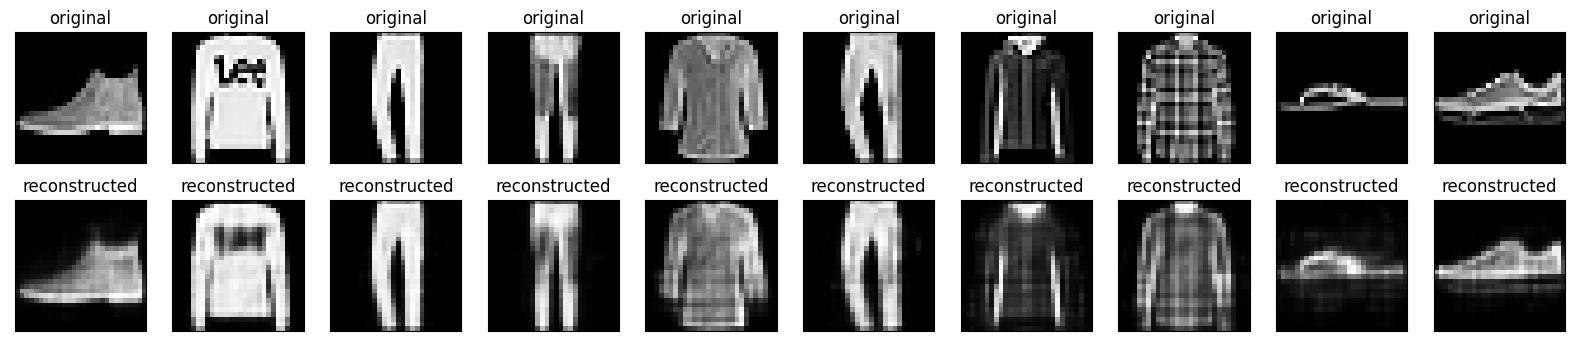

In [8]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## 두 번째 예: 이미지 노이즈 제거

![이미지 노이즈 제거 결과](images/image_denoise_fmnist_results.png)

autoencoder는 이미지에서 노이즈를 제거하도록 훈련될 수도 있습니다. 다음 섹션에서는 각 이미지에 임의의 노이즈를 적용하여 Fashion MNIST 데이터세트의 노이즈 버전을 생성합니다. 그런 다음 노이즈가 있는 이미지를 입력으로 사용하고 원본 이미지를 대상으로 사용하여 autoencoder를 훈련합니다.

이전에 수정한 내용을 생략하기 위해 데이터세트를 다시 가져오겠습니다.

In [9]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [10]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


이미지에 임의의 노이즈를 추가합니다.

In [11]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

노이즈가 있는 이미지를 플롯합니다.


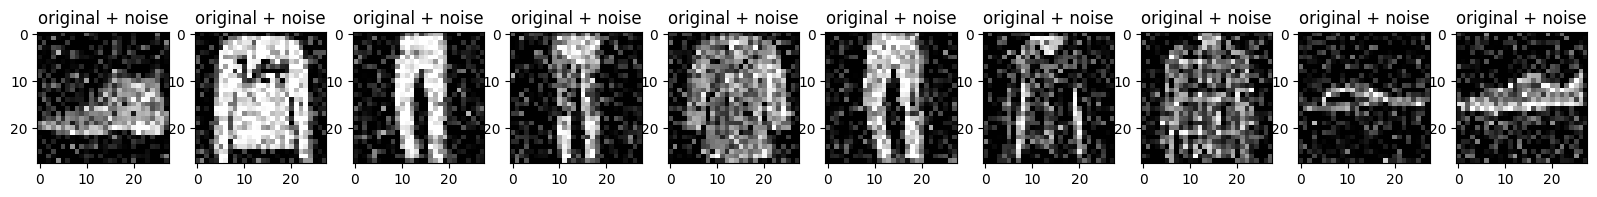

In [12]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

### 컨볼루셔널 autoencoder 정의하기

이 예제에서는 <code>encoder</code>에 <a>Conv2D</a> 레이어를 사용하고 <code>decoder</code>에 <a>Conv2DTranspose</a> 레이어를 사용하여 컨볼루셔널 autoencoder를 훈련합니다.

In [13]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [14]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [15]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10


   1/1875 [..............................] - ETA: 1:37:21 - loss: 0.1734

  13/1875 [..............................] - ETA: 7s - loss: 0.1656     

  26/1875 [..............................] - ETA: 7s - loss: 0.1627

  39/1875 [..............................] - ETA: 7s - loss: 0.1561

  52/1875 [..............................] - ETA: 7s - loss: 0.1451

  65/1875 [>.............................] - ETA: 7s - loss: 0.1265

  79/1875 [>.............................] - ETA: 7s - loss: 0.1095

  92/1875 [>.............................] - ETA: 7s - loss: 0.0979

 105/1875 [>.............................] - ETA: 6s - loss: 0.0888

 118/1875 [>.............................] - ETA: 6s - loss: 0.0816

 131/1875 [=>............................] - ETA: 6s - loss: 0.0758

 144/1875 [=>............................] - ETA: 6s - loss: 0.0709

 157/1875 [=>............................] - ETA: 6s - loss: 0.0666

 170/1875 [=>............................] - ETA: 6s - loss: 0.0631

 183/1875 [=>............................] - ETA: 6s - loss: 0.0599

 196/1875 [==>...........................] - ETA: 6s - loss: 0.0572

 210/1875 [==>...........................] - ETA: 6s - loss: 0.0546

 223/1875 [==>...........................] - ETA: 6s - loss: 0.0524

 236/1875 [==>...........................] - ETA: 6s - loss: 0.0505

 249/1875 [==>...........................] - ETA: 6s - loss: 0.0488

 263/1875 [===>..........................] - ETA: 6s - loss: 0.0470

 276/1875 [===>..........................] - ETA: 6s - loss: 0.0456

 289/1875 [===>..........................] - ETA: 6s - loss: 0.0442

 302/1875 [===>..........................] - ETA: 6s - loss: 0.0430

 315/1875 [====>.........................] - ETA: 6s - loss: 0.0419

 328/1875 [====>.........................] - ETA: 6s - loss: 0.0408

 341/1875 [====>.........................] - ETA: 6s - loss: 0.0398

 354/1875 [====>.........................] - ETA: 5s - loss: 0.0389

 367/1875 [====>.........................] - ETA: 5s - loss: 0.0380

 380/1875 [=====>........................] - ETA: 5s - loss: 0.0372

 394/1875 [=====>........................] - ETA: 5s - loss: 0.0364

 407/1875 [=====>........................] - ETA: 5s - loss: 0.0356

 420/1875 [=====>........................] - ETA: 5s - loss: 0.0350

 433/1875 [=====>........................] - ETA: 5s - loss: 0.0343

 446/1875 [======>.......................] - ETA: 5s - loss: 0.0337

 459/1875 [======>.......................] - ETA: 5s - loss: 0.0331

 472/1875 [======>.......................] - ETA: 5s - loss: 0.0326

 485/1875 [======>.......................] - ETA: 5s - loss: 0.0321

 498/1875 [======>.......................] - ETA: 5s - loss: 0.0316

 511/1875 [=======>......................] - ETA: 5s - loss: 0.0311

 524/1875 [=======>......................] - ETA: 5s - loss: 0.0306

 538/1875 [=======>......................] - ETA: 5s - loss: 0.0301

 552/1875 [=======>......................] - ETA: 5s - loss: 0.0297

 565/1875 [========>.....................] - ETA: 5s - loss: 0.0293

 578/1875 [========>.....................] - ETA: 5s - loss: 0.0289

 592/1875 [========>.....................] - ETA: 5s - loss: 0.0285

 605/1875 [========>.....................] - ETA: 4s - loss: 0.0282

 618/1875 [========>.....................] - ETA: 4s - loss: 0.0278

 631/1875 [=========>....................] - ETA: 4s - loss: 0.0275

 644/1875 [=========>....................] - ETA: 4s - loss: 0.0272

 657/1875 [=========>....................] - ETA: 4s - loss: 0.0269

 671/1875 [=========>....................] - ETA: 4s - loss: 0.0266

 685/1875 [=========>....................] - ETA: 4s - loss: 0.0263

 698/1875 [==========>...................] - ETA: 4s - loss: 0.0260

 711/1875 [==========>...................] - ETA: 4s - loss: 0.0258

 724/1875 [==========>...................] - ETA: 4s - loss: 0.0255

 737/1875 [==========>...................] - ETA: 4s - loss: 0.0252

 751/1875 [===========>..................] - ETA: 4s - loss: 0.0250

 764/1875 [===========>..................] - ETA: 4s - loss: 0.0247

 777/1875 [===========>..................] - ETA: 4s - loss: 0.0245

 790/1875 [===========>..................] - ETA: 4s - loss: 0.0243

 803/1875 [===========>..................] - ETA: 4s - loss: 0.0241

 816/1875 [============>.................] - ETA: 4s - loss: 0.0239

 830/1875 [============>.................] - ETA: 4s - loss: 0.0236

 843/1875 [============>.................] - ETA: 4s - loss: 0.0235

 856/1875 [============>.................] - ETA: 3s - loss: 0.0233

 869/1875 [============>.................] - ETA: 3s - loss: 0.0231

 883/1875 [=============>................] - ETA: 3s - loss: 0.0229

 897/1875 [=============>................] - ETA: 3s - loss: 0.0227

 911/1875 [=============>................] - ETA: 3s - loss: 0.0225

 924/1875 [=============>................] - ETA: 3s - loss: 0.0223

 937/1875 [=============>................] - ETA: 3s - loss: 0.0222

 951/1875 [==============>...............] - ETA: 3s - loss: 0.0220

 964/1875 [==============>...............] - ETA: 3s - loss: 0.0219

 978/1875 [==============>...............] - ETA: 3s - loss: 0.0217

 991/1875 [==============>...............] - ETA: 3s - loss: 0.0215

1004/1875 [===============>..............] - ETA: 3s - loss: 0.0214

1017/1875 [===============>..............] - ETA: 3s - loss: 0.0212

1030/1875 [===============>..............] - ETA: 3s - loss: 0.0211

1043/1875 [===============>..............] - ETA: 3s - loss: 0.0210

1056/1875 [===============>..............] - ETA: 3s - loss: 0.0208

1069/1875 [================>.............] - ETA: 3s - loss: 0.0207

1082/1875 [================>.............] - ETA: 3s - loss: 0.0206

1096/1875 [================>.............] - ETA: 3s - loss: 0.0204

1109/1875 [================>.............] - ETA: 2s - loss: 0.0203

1123/1875 [================>.............] - ETA: 2s - loss: 0.0202

1136/1875 [=================>............] - ETA: 2s - loss: 0.0201

1149/1875 [=================>............] - ETA: 2s - loss: 0.0200

1162/1875 [=================>............] - ETA: 2s - loss: 0.0199

1175/1875 [=================>............] - ETA: 2s - loss: 0.0197

1188/1875 [==================>...........] - ETA: 2s - loss: 0.0196

1201/1875 [==================>...........] - ETA: 2s - loss: 0.0195

1214/1875 [==================>...........] - ETA: 2s - loss: 0.0194

1227/1875 [==================>...........] - ETA: 2s - loss: 0.0193

1240/1875 [==================>...........] - ETA: 2s - loss: 0.0192

1253/1875 [===================>..........] - ETA: 2s - loss: 0.0191

1266/1875 [===================>..........] - ETA: 2s - loss: 0.0190

1279/1875 [===================>..........] - ETA: 2s - loss: 0.0189

1292/1875 [===================>..........] - ETA: 2s - loss: 0.0188

1306/1875 [===================>..........] - ETA: 2s - loss: 0.0187

1319/1875 [====================>.........] - ETA: 2s - loss: 0.0187

1332/1875 [====================>.........] - ETA: 2s - loss: 0.0186

1345/1875 [====================>.........] - ETA: 2s - loss: 0.0185

1358/1875 [====================>.........] - ETA: 2s - loss: 0.0184

1372/1875 [====================>.........] - ETA: 1s - loss: 0.0183

1385/1875 [=====================>........] - ETA: 1s - loss: 0.0182

1398/1875 [=====================>........] - ETA: 1s - loss: 0.0182

1411/1875 [=====================>........] - ETA: 1s - loss: 0.0181

1424/1875 [=====================>........] - ETA: 1s - loss: 0.0180

1437/1875 [=====================>........] - ETA: 1s - loss: 0.0179

1450/1875 [======================>.......] - ETA: 1s - loss: 0.0178

1463/1875 [======================>.......] - ETA: 1s - loss: 0.0178

1476/1875 [======================>.......] - ETA: 1s - loss: 0.0177

1489/1875 [======================>.......] - ETA: 1s - loss: 0.0176

1503/1875 [=======================>......] - ETA: 1s - loss: 0.0175

1517/1875 [=======================>......] - ETA: 1s - loss: 0.0175

1530/1875 [=======================>......] - ETA: 1s - loss: 0.0174

1543/1875 [=======================>......] - ETA: 1s - loss: 0.0173

1556/1875 [=======================>......] - ETA: 1s - loss: 0.0173

1569/1875 [========================>.....] - ETA: 1s - loss: 0.0172

1583/1875 [========================>.....] - ETA: 1s - loss: 0.0171

1596/1875 [========================>.....] - ETA: 1s - loss: 0.0171

1609/1875 [========================>.....] - ETA: 1s - loss: 0.0170

1623/1875 [========================>.....] - ETA: 0s - loss: 0.0169

1637/1875 [=========================>....] - ETA: 0s - loss: 0.0169

1650/1875 [=========================>....] - ETA: 0s - loss: 0.0168

1664/1875 [=========================>....] - ETA: 0s - loss: 0.0168

1677/1875 [=========================>....] - ETA: 0s - loss: 0.0167

1690/1875 [==========================>...] - ETA: 0s - loss: 0.0166

1703/1875 [==========================>...] - ETA: 0s - loss: 0.0166

1716/1875 [==========================>...] - ETA: 0s - loss: 0.0165

1729/1875 [==========================>...] - ETA: 0s - loss: 0.0165

1742/1875 [==========================>...] - ETA: 0s - loss: 0.0164

1755/1875 [===========================>..] - ETA: 0s - loss: 0.0164

1768/1875 [===========================>..] - ETA: 0s - loss: 0.0163

1781/1875 [===========================>..] - ETA: 0s - loss: 0.0163

1794/1875 [===========================>..] - ETA: 0s - loss: 0.0162

1808/1875 [===========================>..] - ETA: 0s - loss: 0.0162

1821/1875 [============================>.] - ETA: 0s - loss: 0.0161

1834/1875 [============================>.] - ETA: 0s - loss: 0.0161

1847/1875 [============================>.] - ETA: 0s - loss: 0.0160

1861/1875 [============================>.] - ETA: 0s - loss: 0.0160

1874/1875 [============================>.] - ETA: 0s - loss: 0.0159

1875/1875 [==============================] - 11s 4ms/step - loss: 0.0159 - val_loss: 0.0090


Epoch 2/10


   1/1875 [..............................] - ETA: 9s - loss: 0.0093

  15/1875 [..............................] - ETA: 7s - loss: 0.0088

  29/1875 [..............................] - ETA: 7s - loss: 0.0090

  42/1875 [..............................] - ETA: 7s - loss: 0.0090

  55/1875 [..............................] - ETA: 7s - loss: 0.0090

  68/1875 [>.............................] - ETA: 7s - loss: 0.0090

  82/1875 [>.............................] - ETA: 6s - loss: 0.0090

  96/1875 [>.............................] - ETA: 6s - loss: 0.0090

 110/1875 [>.............................] - ETA: 6s - loss: 0.0090

 124/1875 [>.............................] - ETA: 6s - loss: 0.0090

 137/1875 [=>............................] - ETA: 6s - loss: 0.0090

 150/1875 [=>............................] - ETA: 6s - loss: 0.0090

 163/1875 [=>............................] - ETA: 6s - loss: 0.0090

 176/1875 [=>............................] - ETA: 6s - loss: 0.0089

 189/1875 [==>...........................] - ETA: 6s - loss: 0.0089

 202/1875 [==>...........................] - ETA: 6s - loss: 0.0089

 215/1875 [==>...........................] - ETA: 6s - loss: 0.0090

 228/1875 [==>...........................] - ETA: 6s - loss: 0.0090

 241/1875 [==>...........................] - ETA: 6s - loss: 0.0089

 254/1875 [===>..........................] - ETA: 6s - loss: 0.0089

 267/1875 [===>..........................] - ETA: 6s - loss: 0.0089

 280/1875 [===>..........................] - ETA: 6s - loss: 0.0089

 293/1875 [===>..........................] - ETA: 6s - loss: 0.0089

 306/1875 [===>..........................] - ETA: 6s - loss: 0.0089

 319/1875 [====>.........................] - ETA: 6s - loss: 0.0089

 332/1875 [====>.........................] - ETA: 6s - loss: 0.0089

 345/1875 [====>.........................] - ETA: 5s - loss: 0.0089

 358/1875 [====>.........................] - ETA: 5s - loss: 0.0089

 371/1875 [====>.........................] - ETA: 5s - loss: 0.0089

 384/1875 [=====>........................] - ETA: 5s - loss: 0.0089

 397/1875 [=====>........................] - ETA: 5s - loss: 0.0088

 410/1875 [=====>........................] - ETA: 5s - loss: 0.0088

 423/1875 [=====>........................] - ETA: 5s - loss: 0.0088

 436/1875 [=====>........................] - ETA: 5s - loss: 0.0088

 449/1875 [======>.......................] - ETA: 5s - loss: 0.0088

 462/1875 [======>.......................] - ETA: 5s - loss: 0.0088

 475/1875 [======>.......................] - ETA: 5s - loss: 0.0088

 489/1875 [======>.......................] - ETA: 5s - loss: 0.0088

 503/1875 [=======>......................] - ETA: 5s - loss: 0.0088

 517/1875 [=======>......................] - ETA: 5s - loss: 0.0088

 530/1875 [=======>......................] - ETA: 5s - loss: 0.0088

 543/1875 [=======>......................] - ETA: 5s - loss: 0.0088

 556/1875 [=======>......................] - ETA: 5s - loss: 0.0088

 569/1875 [========>.....................] - ETA: 5s - loss: 0.0088

 582/1875 [========>.....................] - ETA: 5s - loss: 0.0088

 595/1875 [========>.....................] - ETA: 5s - loss: 0.0088

 608/1875 [========>.....................] - ETA: 4s - loss: 0.0088

 621/1875 [========>.....................] - ETA: 4s - loss: 0.0088

 634/1875 [=========>....................] - ETA: 4s - loss: 0.0088

 647/1875 [=========>....................] - ETA: 4s - loss: 0.0087

 660/1875 [=========>....................] - ETA: 4s - loss: 0.0087

 673/1875 [=========>....................] - ETA: 4s - loss: 0.0087

 686/1875 [=========>....................] - ETA: 4s - loss: 0.0087

 699/1875 [==========>...................] - ETA: 4s - loss: 0.0087

 712/1875 [==========>...................] - ETA: 4s - loss: 0.0087

 726/1875 [==========>...................] - ETA: 4s - loss: 0.0087

 739/1875 [==========>...................] - ETA: 4s - loss: 0.0087

 752/1875 [===========>..................] - ETA: 4s - loss: 0.0087

 766/1875 [===========>..................] - ETA: 4s - loss: 0.0087

 779/1875 [===========>..................] - ETA: 4s - loss: 0.0087

 792/1875 [===========>..................] - ETA: 4s - loss: 0.0087

 805/1875 [===========>..................] - ETA: 4s - loss: 0.0087

 818/1875 [============>.................] - ETA: 4s - loss: 0.0087

 831/1875 [============>.................] - ETA: 4s - loss: 0.0087

 844/1875 [============>.................] - ETA: 4s - loss: 0.0087

 857/1875 [============>.................] - ETA: 3s - loss: 0.0087

 870/1875 [============>.................] - ETA: 3s - loss: 0.0087

 884/1875 [=============>................] - ETA: 3s - loss: 0.0087

 897/1875 [=============>................] - ETA: 3s - loss: 0.0087

 910/1875 [=============>................] - ETA: 3s - loss: 0.0087

 924/1875 [=============>................] - ETA: 3s - loss: 0.0087

 937/1875 [=============>................] - ETA: 3s - loss: 0.0086

 950/1875 [==============>...............] - ETA: 3s - loss: 0.0086

 963/1875 [==============>...............] - ETA: 3s - loss: 0.0086

 976/1875 [==============>...............] - ETA: 3s - loss: 0.0086

 989/1875 [==============>...............] - ETA: 3s - loss: 0.0086

1003/1875 [===============>..............] - ETA: 3s - loss: 0.0086

1016/1875 [===============>..............] - ETA: 3s - loss: 0.0086

1029/1875 [===============>..............] - ETA: 3s - loss: 0.0086

1042/1875 [===============>..............] - ETA: 3s - loss: 0.0086

1055/1875 [===============>..............] - ETA: 3s - loss: 0.0086

1069/1875 [================>.............] - ETA: 3s - loss: 0.0086

1082/1875 [================>.............] - ETA: 3s - loss: 0.0086

1095/1875 [================>.............] - ETA: 3s - loss: 0.0086

1108/1875 [================>.............] - ETA: 3s - loss: 0.0086

1121/1875 [================>.............] - ETA: 2s - loss: 0.0086

1134/1875 [=================>............] - ETA: 2s - loss: 0.0086

1147/1875 [=================>............] - ETA: 2s - loss: 0.0086

1160/1875 [=================>............] - ETA: 2s - loss: 0.0086

1173/1875 [=================>............] - ETA: 2s - loss: 0.0086

1186/1875 [=================>............] - ETA: 2s - loss: 0.0086

1199/1875 [==================>...........] - ETA: 2s - loss: 0.0086

1212/1875 [==================>...........] - ETA: 2s - loss: 0.0086

1225/1875 [==================>...........] - ETA: 2s - loss: 0.0086

1238/1875 [==================>...........] - ETA: 2s - loss: 0.0086

1251/1875 [===================>..........] - ETA: 2s - loss: 0.0085

1264/1875 [===================>..........] - ETA: 2s - loss: 0.0085

1277/1875 [===================>..........] - ETA: 2s - loss: 0.0085

1290/1875 [===================>..........] - ETA: 2s - loss: 0.0085

1303/1875 [===================>..........] - ETA: 2s - loss: 0.0085

1316/1875 [====================>.........] - ETA: 2s - loss: 0.0085

1329/1875 [====================>.........] - ETA: 2s - loss: 0.0085

1342/1875 [====================>.........] - ETA: 2s - loss: 0.0085

1355/1875 [====================>.........] - ETA: 2s - loss: 0.0085

1368/1875 [====================>.........] - ETA: 1s - loss: 0.0085

1381/1875 [=====================>........] - ETA: 1s - loss: 0.0085

1394/1875 [=====================>........] - ETA: 1s - loss: 0.0085

1407/1875 [=====================>........] - ETA: 1s - loss: 0.0085

1419/1875 [=====================>........] - ETA: 1s - loss: 0.0085

1431/1875 [=====================>........] - ETA: 1s - loss: 0.0085

1444/1875 [======================>.......] - ETA: 1s - loss: 0.0085

1458/1875 [======================>.......] - ETA: 1s - loss: 0.0085

1471/1875 [======================>.......] - ETA: 1s - loss: 0.0085

1484/1875 [======================>.......] - ETA: 1s - loss: 0.0085

1497/1875 [======================>.......] - ETA: 1s - loss: 0.0085

1510/1875 [=======================>......] - ETA: 1s - loss: 0.0085

1523/1875 [=======================>......] - ETA: 1s - loss: 0.0085

1536/1875 [=======================>......] - ETA: 1s - loss: 0.0085

1549/1875 [=======================>......] - ETA: 1s - loss: 0.0085

1562/1875 [=======================>......] - ETA: 1s - loss: 0.0085

1575/1875 [========================>.....] - ETA: 1s - loss: 0.0085

1588/1875 [========================>.....] - ETA: 1s - loss: 0.0085

1601/1875 [========================>.....] - ETA: 1s - loss: 0.0085

1615/1875 [========================>.....] - ETA: 1s - loss: 0.0085

1628/1875 [=========================>....] - ETA: 0s - loss: 0.0085

1641/1875 [=========================>....] - ETA: 0s - loss: 0.0085

1655/1875 [=========================>....] - ETA: 0s - loss: 0.0085

1668/1875 [=========================>....] - ETA: 0s - loss: 0.0084

1682/1875 [=========================>....] - ETA: 0s - loss: 0.0084

1695/1875 [==========================>...] - ETA: 0s - loss: 0.0084

1708/1875 [==========================>...] - ETA: 0s - loss: 0.0084

1721/1875 [==========================>...] - ETA: 0s - loss: 0.0084

1734/1875 [==========================>...] - ETA: 0s - loss: 0.0084

1747/1875 [==========================>...] - ETA: 0s - loss: 0.0084

1760/1875 [===========================>..] - ETA: 0s - loss: 0.0084

1773/1875 [===========================>..] - ETA: 0s - loss: 0.0084

1786/1875 [===========================>..] - ETA: 0s - loss: 0.0084

1799/1875 [===========================>..] - ETA: 0s - loss: 0.0084

1812/1875 [===========================>..] - ETA: 0s - loss: 0.0084

1825/1875 [============================>.] - ETA: 0s - loss: 0.0084

1838/1875 [============================>.] - ETA: 0s - loss: 0.0084

1851/1875 [============================>.] - ETA: 0s - loss: 0.0084

1864/1875 [============================>.] - ETA: 0s - loss: 0.0084

1875/1875 [==============================] - 8s 4ms/step - loss: 0.0084 - val_loss: 0.0080


Epoch 3/10


   1/1875 [..............................] - ETA: 9s - loss: 0.0077

  14/1875 [..............................] - ETA: 7s - loss: 0.0079

  27/1875 [..............................] - ETA: 7s - loss: 0.0081

  40/1875 [..............................] - ETA: 7s - loss: 0.0081

  53/1875 [..............................] - ETA: 7s - loss: 0.0081

  66/1875 [>.............................] - ETA: 7s - loss: 0.0081

  79/1875 [>.............................] - ETA: 7s - loss: 0.0081

  92/1875 [>.............................] - ETA: 6s - loss: 0.0081

 105/1875 [>.............................] - ETA: 6s - loss: 0.0080

 118/1875 [>.............................] - ETA: 6s - loss: 0.0080

 131/1875 [=>............................] - ETA: 6s - loss: 0.0080

 144/1875 [=>............................] - ETA: 6s - loss: 0.0080

 157/1875 [=>............................] - ETA: 6s - loss: 0.0080

 170/1875 [=>............................] - ETA: 6s - loss: 0.0080

 183/1875 [=>............................] - ETA: 6s - loss: 0.0080

 196/1875 [==>...........................] - ETA: 6s - loss: 0.0079

 209/1875 [==>...........................] - ETA: 6s - loss: 0.0079

 222/1875 [==>...........................] - ETA: 6s - loss: 0.0079

 235/1875 [==>...........................] - ETA: 6s - loss: 0.0079

 248/1875 [==>...........................] - ETA: 6s - loss: 0.0079

 261/1875 [===>..........................] - ETA: 6s - loss: 0.0079

 274/1875 [===>..........................] - ETA: 6s - loss: 0.0079

 287/1875 [===>..........................] - ETA: 6s - loss: 0.0079

 300/1875 [===>..........................] - ETA: 6s - loss: 0.0079

 313/1875 [====>.........................] - ETA: 6s - loss: 0.0079

 327/1875 [====>.........................] - ETA: 6s - loss: 0.0079

 340/1875 [====>.........................] - ETA: 6s - loss: 0.0079

 353/1875 [====>.........................] - ETA: 5s - loss: 0.0079

 366/1875 [====>.........................] - ETA: 5s - loss: 0.0079

 379/1875 [=====>........................] - ETA: 5s - loss: 0.0079

 392/1875 [=====>........................] - ETA: 5s - loss: 0.0079

 405/1875 [=====>........................] - ETA: 5s - loss: 0.0079

 418/1875 [=====>........................] - ETA: 5s - loss: 0.0079

 431/1875 [=====>........................] - ETA: 5s - loss: 0.0079

 444/1875 [======>.......................] - ETA: 5s - loss: 0.0079

 457/1875 [======>.......................] - ETA: 5s - loss: 0.0079

 470/1875 [======>.......................] - ETA: 5s - loss: 0.0079

 483/1875 [======>.......................] - ETA: 5s - loss: 0.0079

 496/1875 [======>.......................] - ETA: 5s - loss: 0.0079

 510/1875 [=======>......................] - ETA: 5s - loss: 0.0079

 524/1875 [=======>......................] - ETA: 5s - loss: 0.0079

 537/1875 [=======>......................] - ETA: 5s - loss: 0.0079

 550/1875 [=======>......................] - ETA: 5s - loss: 0.0079

 564/1875 [========>.....................] - ETA: 5s - loss: 0.0079

 577/1875 [========>.....................] - ETA: 5s - loss: 0.0079

 590/1875 [========>.....................] - ETA: 5s - loss: 0.0079

 603/1875 [========>.....................] - ETA: 4s - loss: 0.0079

 617/1875 [========>.....................] - ETA: 4s - loss: 0.0079

 630/1875 [=========>....................] - ETA: 4s - loss: 0.0079

 643/1875 [=========>....................] - ETA: 4s - loss: 0.0079

 656/1875 [=========>....................] - ETA: 4s - loss: 0.0079

 669/1875 [=========>....................] - ETA: 4s - loss: 0.0079

 682/1875 [=========>....................] - ETA: 4s - loss: 0.0079

 695/1875 [==========>...................] - ETA: 4s - loss: 0.0079

 708/1875 [==========>...................] - ETA: 4s - loss: 0.0079

 722/1875 [==========>...................] - ETA: 4s - loss: 0.0079

 735/1875 [==========>...................] - ETA: 4s - loss: 0.0078

 749/1875 [==========>...................] - ETA: 4s - loss: 0.0078

 762/1875 [===========>..................] - ETA: 4s - loss: 0.0078

 776/1875 [===========>..................] - ETA: 4s - loss: 0.0078

 790/1875 [===========>..................] - ETA: 4s - loss: 0.0078

 804/1875 [===========>..................] - ETA: 4s - loss: 0.0078

 818/1875 [============>.................] - ETA: 4s - loss: 0.0078

 832/1875 [============>.................] - ETA: 4s - loss: 0.0078

 845/1875 [============>.................] - ETA: 4s - loss: 0.0078

 858/1875 [============>.................] - ETA: 3s - loss: 0.0078

 871/1875 [============>.................] - ETA: 3s - loss: 0.0078

 884/1875 [=============>................] - ETA: 3s - loss: 0.0078

 898/1875 [=============>................] - ETA: 3s - loss: 0.0078

 911/1875 [=============>................] - ETA: 3s - loss: 0.0078

 924/1875 [=============>................] - ETA: 3s - loss: 0.0078

 937/1875 [=============>................] - ETA: 3s - loss: 0.0078

 950/1875 [==============>...............] - ETA: 3s - loss: 0.0078

 964/1875 [==============>...............] - ETA: 3s - loss: 0.0078

 978/1875 [==============>...............] - ETA: 3s - loss: 0.0078

 991/1875 [==============>...............] - ETA: 3s - loss: 0.0078

1004/1875 [===============>..............] - ETA: 3s - loss: 0.0078

1017/1875 [===============>..............] - ETA: 3s - loss: 0.0078

1030/1875 [===============>..............] - ETA: 3s - loss: 0.0078

1043/1875 [===============>..............] - ETA: 3s - loss: 0.0078

1056/1875 [===============>..............] - ETA: 3s - loss: 0.0078

1069/1875 [================>.............] - ETA: 3s - loss: 0.0078

1083/1875 [================>.............] - ETA: 3s - loss: 0.0078

1096/1875 [================>.............] - ETA: 3s - loss: 0.0078

1109/1875 [================>.............] - ETA: 2s - loss: 0.0078

1122/1875 [================>.............] - ETA: 2s - loss: 0.0078

1135/1875 [=================>............] - ETA: 2s - loss: 0.0078

1148/1875 [=================>............] - ETA: 2s - loss: 0.0078

1161/1875 [=================>............] - ETA: 2s - loss: 0.0078

1174/1875 [=================>............] - ETA: 2s - loss: 0.0078

1187/1875 [=================>............] - ETA: 2s - loss: 0.0078

1200/1875 [==================>...........] - ETA: 2s - loss: 0.0078

1213/1875 [==================>...........] - ETA: 2s - loss: 0.0078

1226/1875 [==================>...........] - ETA: 2s - loss: 0.0078

1239/1875 [==================>...........] - ETA: 2s - loss: 0.0078

1252/1875 [===================>..........] - ETA: 2s - loss: 0.0078

1265/1875 [===================>..........] - ETA: 2s - loss: 0.0078

1278/1875 [===================>..........] - ETA: 2s - loss: 0.0078

1291/1875 [===================>..........] - ETA: 2s - loss: 0.0078

1304/1875 [===================>..........] - ETA: 2s - loss: 0.0078

1317/1875 [====================>.........] - ETA: 2s - loss: 0.0078

1330/1875 [====================>.........] - ETA: 2s - loss: 0.0078

1343/1875 [====================>.........] - ETA: 2s - loss: 0.0078

1356/1875 [====================>.........] - ETA: 2s - loss: 0.0078

1370/1875 [====================>.........] - ETA: 1s - loss: 0.0078

1383/1875 [=====================>........] - ETA: 1s - loss: 0.0078

1396/1875 [=====================>........] - ETA: 1s - loss: 0.0078

1409/1875 [=====================>........] - ETA: 1s - loss: 0.0078

1422/1875 [=====================>........] - ETA: 1s - loss: 0.0078

1435/1875 [=====================>........] - ETA: 1s - loss: 0.0078

1449/1875 [======================>.......] - ETA: 1s - loss: 0.0078

1462/1875 [======================>.......] - ETA: 1s - loss: 0.0078

1475/1875 [======================>.......] - ETA: 1s - loss: 0.0078

1488/1875 [======================>.......] - ETA: 1s - loss: 0.0078

1501/1875 [=======================>......] - ETA: 1s - loss: 0.0078

1514/1875 [=======================>......] - ETA: 1s - loss: 0.0078

1527/1875 [=======================>......] - ETA: 1s - loss: 0.0078

1540/1875 [=======================>......] - ETA: 1s - loss: 0.0077

1553/1875 [=======================>......] - ETA: 1s - loss: 0.0077

1566/1875 [========================>.....] - ETA: 1s - loss: 0.0077

1579/1875 [========================>.....] - ETA: 1s - loss: 0.0077

1592/1875 [========================>.....] - ETA: 1s - loss: 0.0077

1605/1875 [========================>.....] - ETA: 1s - loss: 0.0077

1618/1875 [========================>.....] - ETA: 1s - loss: 0.0077

1631/1875 [=========================>....] - ETA: 0s - loss: 0.0077

1644/1875 [=========================>....] - ETA: 0s - loss: 0.0077

1657/1875 [=========================>....] - ETA: 0s - loss: 0.0077

1670/1875 [=========================>....] - ETA: 0s - loss: 0.0077

1683/1875 [=========================>....] - ETA: 0s - loss: 0.0077

1696/1875 [==========================>...] - ETA: 0s - loss: 0.0077

1709/1875 [==========================>...] - ETA: 0s - loss: 0.0077

1723/1875 [==========================>...] - ETA: 0s - loss: 0.0077

1736/1875 [==========================>...] - ETA: 0s - loss: 0.0077

1749/1875 [==========================>...] - ETA: 0s - loss: 0.0077

1762/1875 [===========================>..] - ETA: 0s - loss: 0.0077

1775/1875 [===========================>..] - ETA: 0s - loss: 0.0077

1788/1875 [===========================>..] - ETA: 0s - loss: 0.0077

1801/1875 [===========================>..] - ETA: 0s - loss: 0.0077

1815/1875 [============================>.] - ETA: 0s - loss: 0.0077

1829/1875 [============================>.] - ETA: 0s - loss: 0.0077

1842/1875 [============================>.] - ETA: 0s - loss: 0.0077

1855/1875 [============================>.] - ETA: 0s - loss: 0.0077

1868/1875 [============================>.] - ETA: 0s - loss: 0.0077

1875/1875 [==============================] - 8s 4ms/step - loss: 0.0077 - val_loss: 0.0075


Epoch 4/10


   1/1875 [..............................] - ETA: 9s - loss: 0.0075

  15/1875 [..............................] - ETA: 7s - loss: 0.0074

  29/1875 [..............................] - ETA: 6s - loss: 0.0074

  43/1875 [..............................] - ETA: 6s - loss: 0.0074

  57/1875 [..............................] - ETA: 6s - loss: 0.0074

  70/1875 [>.............................] - ETA: 6s - loss: 0.0074

  83/1875 [>.............................] - ETA: 6s - loss: 0.0075

  96/1875 [>.............................] - ETA: 6s - loss: 0.0075

 110/1875 [>.............................] - ETA: 6s - loss: 0.0075

 123/1875 [>.............................] - ETA: 6s - loss: 0.0075

 136/1875 [=>............................] - ETA: 6s - loss: 0.0075

 149/1875 [=>............................] - ETA: 6s - loss: 0.0075

 162/1875 [=>............................] - ETA: 6s - loss: 0.0075

 175/1875 [=>............................] - ETA: 6s - loss: 0.0075

 188/1875 [==>...........................] - ETA: 6s - loss: 0.0075

 201/1875 [==>...........................] - ETA: 6s - loss: 0.0075

 213/1875 [==>...........................] - ETA: 6s - loss: 0.0075

 226/1875 [==>...........................] - ETA: 6s - loss: 0.0075

 239/1875 [==>...........................] - ETA: 6s - loss: 0.0075

 252/1875 [===>..........................] - ETA: 6s - loss: 0.0075

 266/1875 [===>..........................] - ETA: 6s - loss: 0.0075

 279/1875 [===>..........................] - ETA: 6s - loss: 0.0075

 292/1875 [===>..........................] - ETA: 6s - loss: 0.0075

 306/1875 [===>..........................] - ETA: 6s - loss: 0.0075

 320/1875 [====>.........................] - ETA: 6s - loss: 0.0075

 333/1875 [====>.........................] - ETA: 6s - loss: 0.0075

 346/1875 [====>.........................] - ETA: 5s - loss: 0.0075

 360/1875 [====>.........................] - ETA: 5s - loss: 0.0075

 373/1875 [====>.........................] - ETA: 5s - loss: 0.0075

 386/1875 [=====>........................] - ETA: 5s - loss: 0.0075

 399/1875 [=====>........................] - ETA: 5s - loss: 0.0075

 412/1875 [=====>........................] - ETA: 5s - loss: 0.0075

 425/1875 [=====>........................] - ETA: 5s - loss: 0.0075

 438/1875 [======>.......................] - ETA: 5s - loss: 0.0075

 451/1875 [======>.......................] - ETA: 5s - loss: 0.0075

 464/1875 [======>.......................] - ETA: 5s - loss: 0.0075

 477/1875 [======>.......................] - ETA: 5s - loss: 0.0075

 490/1875 [======>.......................] - ETA: 5s - loss: 0.0075

 503/1875 [=======>......................] - ETA: 5s - loss: 0.0075

 517/1875 [=======>......................] - ETA: 5s - loss: 0.0075

 530/1875 [=======>......................] - ETA: 5s - loss: 0.0075

 543/1875 [=======>......................] - ETA: 5s - loss: 0.0075

 556/1875 [=======>......................] - ETA: 5s - loss: 0.0074

 570/1875 [========>.....................] - ETA: 5s - loss: 0.0075

 584/1875 [========>.....................] - ETA: 5s - loss: 0.0075

 598/1875 [========>.....................] - ETA: 4s - loss: 0.0075

 612/1875 [========>.....................] - ETA: 4s - loss: 0.0075

 626/1875 [=========>....................] - ETA: 4s - loss: 0.0075

 639/1875 [=========>....................] - ETA: 4s - loss: 0.0075

 652/1875 [=========>....................] - ETA: 4s - loss: 0.0075

 665/1875 [=========>....................] - ETA: 4s - loss: 0.0075

 678/1875 [=========>....................] - ETA: 4s - loss: 0.0075

 692/1875 [==========>...................] - ETA: 4s - loss: 0.0075

 706/1875 [==========>...................] - ETA: 4s - loss: 0.0075

 720/1875 [==========>...................] - ETA: 4s - loss: 0.0074

 734/1875 [==========>...................] - ETA: 4s - loss: 0.0074

 748/1875 [==========>...................] - ETA: 4s - loss: 0.0074

 761/1875 [===========>..................] - ETA: 4s - loss: 0.0074

 774/1875 [===========>..................] - ETA: 4s - loss: 0.0074

 787/1875 [===========>..................] - ETA: 4s - loss: 0.0074

 800/1875 [===========>..................] - ETA: 4s - loss: 0.0074

 813/1875 [============>.................] - ETA: 4s - loss: 0.0074

 826/1875 [============>.................] - ETA: 4s - loss: 0.0074

 840/1875 [============>.................] - ETA: 4s - loss: 0.0074

 853/1875 [============>.................] - ETA: 3s - loss: 0.0074

 866/1875 [============>.................] - ETA: 3s - loss: 0.0075

 880/1875 [=============>................] - ETA: 3s - loss: 0.0075

 894/1875 [=============>................] - ETA: 3s - loss: 0.0074

 907/1875 [=============>................] - ETA: 3s - loss: 0.0074

 920/1875 [=============>................] - ETA: 3s - loss: 0.0074

 933/1875 [=============>................] - ETA: 3s - loss: 0.0074

 946/1875 [==============>...............] - ETA: 3s - loss: 0.0074

 959/1875 [==============>...............] - ETA: 3s - loss: 0.0074

 973/1875 [==============>...............] - ETA: 3s - loss: 0.0074

 986/1875 [==============>...............] - ETA: 3s - loss: 0.0074

 999/1875 [==============>...............] - ETA: 3s - loss: 0.0074

1012/1875 [===============>..............] - ETA: 3s - loss: 0.0074

1025/1875 [===============>..............] - ETA: 3s - loss: 0.0074

1038/1875 [===============>..............] - ETA: 3s - loss: 0.0074

1051/1875 [===============>..............] - ETA: 3s - loss: 0.0074

1064/1875 [================>.............] - ETA: 3s - loss: 0.0074

1077/1875 [================>.............] - ETA: 3s - loss: 0.0074

1090/1875 [================>.............] - ETA: 3s - loss: 0.0074

1104/1875 [================>.............] - ETA: 2s - loss: 0.0074

1117/1875 [================>.............] - ETA: 2s - loss: 0.0074

1130/1875 [=================>............] - ETA: 2s - loss: 0.0074

1143/1875 [=================>............] - ETA: 2s - loss: 0.0074

1157/1875 [=================>............] - ETA: 2s - loss: 0.0074

1171/1875 [=================>............] - ETA: 2s - loss: 0.0074

1184/1875 [=================>............] - ETA: 2s - loss: 0.0074

1196/1875 [==================>...........] - ETA: 2s - loss: 0.0074

1209/1875 [==================>...........] - ETA: 2s - loss: 0.0074

1222/1875 [==================>...........] - ETA: 2s - loss: 0.0074

1235/1875 [==================>...........] - ETA: 2s - loss: 0.0074

1248/1875 [==================>...........] - ETA: 2s - loss: 0.0074

1262/1875 [===================>..........] - ETA: 2s - loss: 0.0074

1275/1875 [===================>..........] - ETA: 2s - loss: 0.0074

1288/1875 [===================>..........] - ETA: 2s - loss: 0.0074

1301/1875 [===================>..........] - ETA: 2s - loss: 0.0074

1314/1875 [====================>.........] - ETA: 2s - loss: 0.0074

1327/1875 [====================>.........] - ETA: 2s - loss: 0.0074

1340/1875 [====================>.........] - ETA: 2s - loss: 0.0074

1353/1875 [====================>.........] - ETA: 2s - loss: 0.0074

1366/1875 [====================>.........] - ETA: 1s - loss: 0.0074

1379/1875 [=====================>........] - ETA: 1s - loss: 0.0074

1392/1875 [=====================>........] - ETA: 1s - loss: 0.0074

1405/1875 [=====================>........] - ETA: 1s - loss: 0.0074

1418/1875 [=====================>........] - ETA: 1s - loss: 0.0074

1431/1875 [=====================>........] - ETA: 1s - loss: 0.0074

1444/1875 [======================>.......] - ETA: 1s - loss: 0.0074

1457/1875 [======================>.......] - ETA: 1s - loss: 0.0074

1470/1875 [======================>.......] - ETA: 1s - loss: 0.0074

1483/1875 [======================>.......] - ETA: 1s - loss: 0.0074

1496/1875 [======================>.......] - ETA: 1s - loss: 0.0074

1509/1875 [=======================>......] - ETA: 1s - loss: 0.0074

1522/1875 [=======================>......] - ETA: 1s - loss: 0.0074

1535/1875 [=======================>......] - ETA: 1s - loss: 0.0074

1548/1875 [=======================>......] - ETA: 1s - loss: 0.0074

1561/1875 [=======================>......] - ETA: 1s - loss: 0.0074

1574/1875 [========================>.....] - ETA: 1s - loss: 0.0074

1587/1875 [========================>.....] - ETA: 1s - loss: 0.0074

1600/1875 [========================>.....] - ETA: 1s - loss: 0.0074

1613/1875 [========================>.....] - ETA: 1s - loss: 0.0074

1626/1875 [=========================>....] - ETA: 0s - loss: 0.0074

1639/1875 [=========================>....] - ETA: 0s - loss: 0.0074

1652/1875 [=========================>....] - ETA: 0s - loss: 0.0074

1665/1875 [=========================>....] - ETA: 0s - loss: 0.0074

1678/1875 [=========================>....] - ETA: 0s - loss: 0.0074

1691/1875 [==========================>...] - ETA: 0s - loss: 0.0074

1704/1875 [==========================>...] - ETA: 0s - loss: 0.0074

1717/1875 [==========================>...] - ETA: 0s - loss: 0.0074

1730/1875 [==========================>...] - ETA: 0s - loss: 0.0074

1743/1875 [==========================>...] - ETA: 0s - loss: 0.0074

1757/1875 [===========================>..] - ETA: 0s - loss: 0.0074

1770/1875 [===========================>..] - ETA: 0s - loss: 0.0074

1783/1875 [===========================>..] - ETA: 0s - loss: 0.0074

1796/1875 [===========================>..] - ETA: 0s - loss: 0.0074

1809/1875 [===========================>..] - ETA: 0s - loss: 0.0074

1822/1875 [============================>.] - ETA: 0s - loss: 0.0074

1835/1875 [============================>.] - ETA: 0s - loss: 0.0074

1848/1875 [============================>.] - ETA: 0s - loss: 0.0074

1862/1875 [============================>.] - ETA: 0s - loss: 0.0074

1875/1875 [==============================] - 8s 4ms/step - loss: 0.0074 - val_loss: 0.0073


Epoch 5/10


   1/1875 [..............................] - ETA: 10s - loss: 0.0076

  14/1875 [..............................] - ETA: 7s - loss: 0.0072 

  27/1875 [..............................] - ETA: 7s - loss: 0.0072

  40/1875 [..............................] - ETA: 7s - loss: 0.0073

  54/1875 [..............................] - ETA: 7s - loss: 0.0073

  68/1875 [>.............................] - ETA: 6s - loss: 0.0073

  81/1875 [>.............................] - ETA: 6s - loss: 0.0073

  95/1875 [>.............................] - ETA: 6s - loss: 0.0074

 108/1875 [>.............................] - ETA: 6s - loss: 0.0074

 122/1875 [>.............................] - ETA: 6s - loss: 0.0074

 135/1875 [=>............................] - ETA: 6s - loss: 0.0074

 148/1875 [=>............................] - ETA: 6s - loss: 0.0073

 162/1875 [=>............................] - ETA: 6s - loss: 0.0073

 175/1875 [=>............................] - ETA: 6s - loss: 0.0073

 188/1875 [==>...........................] - ETA: 6s - loss: 0.0073

 201/1875 [==>...........................] - ETA: 6s - loss: 0.0073

 214/1875 [==>...........................] - ETA: 6s - loss: 0.0073

 227/1875 [==>...........................] - ETA: 6s - loss: 0.0073

 241/1875 [==>...........................] - ETA: 6s - loss: 0.0073

 254/1875 [===>..........................] - ETA: 6s - loss: 0.0074

 267/1875 [===>..........................] - ETA: 6s - loss: 0.0073

 280/1875 [===>..........................] - ETA: 6s - loss: 0.0073

 293/1875 [===>..........................] - ETA: 6s - loss: 0.0073

 307/1875 [===>..........................] - ETA: 6s - loss: 0.0073

 320/1875 [====>.........................] - ETA: 6s - loss: 0.0073

 333/1875 [====>.........................] - ETA: 5s - loss: 0.0073

 346/1875 [====>.........................] - ETA: 5s - loss: 0.0073

 360/1875 [====>.........................] - ETA: 5s - loss: 0.0073

 373/1875 [====>.........................] - ETA: 5s - loss: 0.0073

 386/1875 [=====>........................] - ETA: 5s - loss: 0.0073

 399/1875 [=====>........................] - ETA: 5s - loss: 0.0073

 412/1875 [=====>........................] - ETA: 5s - loss: 0.0073

 426/1875 [=====>........................] - ETA: 5s - loss: 0.0073

 439/1875 [======>.......................] - ETA: 5s - loss: 0.0073

 452/1875 [======>.......................] - ETA: 5s - loss: 0.0073

 465/1875 [======>.......................] - ETA: 5s - loss: 0.0073

 479/1875 [======>.......................] - ETA: 5s - loss: 0.0073

 493/1875 [======>.......................] - ETA: 5s - loss: 0.0073

 507/1875 [=======>......................] - ETA: 5s - loss: 0.0073

 520/1875 [=======>......................] - ETA: 5s - loss: 0.0073

 533/1875 [=======>......................] - ETA: 5s - loss: 0.0073

 546/1875 [=======>......................] - ETA: 5s - loss: 0.0073

 559/1875 [=======>......................] - ETA: 5s - loss: 0.0073

 573/1875 [========>.....................] - ETA: 5s - loss: 0.0073

 586/1875 [========>.....................] - ETA: 4s - loss: 0.0073

 599/1875 [========>.....................] - ETA: 4s - loss: 0.0073

 613/1875 [========>.....................] - ETA: 4s - loss: 0.0073

 626/1875 [=========>....................] - ETA: 4s - loss: 0.0073

 639/1875 [=========>....................] - ETA: 4s - loss: 0.0073

 652/1875 [=========>....................] - ETA: 4s - loss: 0.0073

 665/1875 [=========>....................] - ETA: 4s - loss: 0.0073

 678/1875 [=========>....................] - ETA: 4s - loss: 0.0073

 691/1875 [==========>...................] - ETA: 4s - loss: 0.0073

 704/1875 [==========>...................] - ETA: 4s - loss: 0.0073

 717/1875 [==========>...................] - ETA: 4s - loss: 0.0073

 730/1875 [==========>...................] - ETA: 4s - loss: 0.0073

 744/1875 [==========>...................] - ETA: 4s - loss: 0.0073

 757/1875 [===========>..................] - ETA: 4s - loss: 0.0073

 770/1875 [===========>..................] - ETA: 4s - loss: 0.0073

 783/1875 [===========>..................] - ETA: 4s - loss: 0.0073

 797/1875 [===========>..................] - ETA: 4s - loss: 0.0073

 810/1875 [===========>..................] - ETA: 4s - loss: 0.0073

 823/1875 [============>.................] - ETA: 4s - loss: 0.0073

 837/1875 [============>.................] - ETA: 4s - loss: 0.0073

 851/1875 [============>.................] - ETA: 3s - loss: 0.0073

 864/1875 [============>.................] - ETA: 3s - loss: 0.0073

 877/1875 [=============>................] - ETA: 3s - loss: 0.0073

 890/1875 [=============>................] - ETA: 3s - loss: 0.0073

 903/1875 [=============>................] - ETA: 3s - loss: 0.0073

 917/1875 [=============>................] - ETA: 3s - loss: 0.0073

 930/1875 [=============>................] - ETA: 3s - loss: 0.0073

 943/1875 [==============>...............] - ETA: 3s - loss: 0.0073

 956/1875 [==============>...............] - ETA: 3s - loss: 0.0073

 970/1875 [==============>...............] - ETA: 3s - loss: 0.0073

 983/1875 [==============>...............] - ETA: 3s - loss: 0.0073

 996/1875 [==============>...............] - ETA: 3s - loss: 0.0073

1009/1875 [===============>..............] - ETA: 3s - loss: 0.0073

1023/1875 [===============>..............] - ETA: 3s - loss: 0.0073

1037/1875 [===============>..............] - ETA: 3s - loss: 0.0073

1050/1875 [===============>..............] - ETA: 3s - loss: 0.0073

1063/1875 [================>.............] - ETA: 3s - loss: 0.0073

1076/1875 [================>.............] - ETA: 3s - loss: 0.0073

1090/1875 [================>.............] - ETA: 3s - loss: 0.0073

1103/1875 [================>.............] - ETA: 2s - loss: 0.0073

1116/1875 [================>.............] - ETA: 2s - loss: 0.0073

1129/1875 [=================>............] - ETA: 2s - loss: 0.0073

1142/1875 [=================>............] - ETA: 2s - loss: 0.0073

1155/1875 [=================>............] - ETA: 2s - loss: 0.0073

1168/1875 [=================>............] - ETA: 2s - loss: 0.0073

1182/1875 [=================>............] - ETA: 2s - loss: 0.0073

1195/1875 [==================>...........] - ETA: 2s - loss: 0.0073

1208/1875 [==================>...........] - ETA: 2s - loss: 0.0073

1221/1875 [==================>...........] - ETA: 2s - loss: 0.0073

1234/1875 [==================>...........] - ETA: 2s - loss: 0.0073

1248/1875 [==================>...........] - ETA: 2s - loss: 0.0073

1262/1875 [===================>..........] - ETA: 2s - loss: 0.0073

1275/1875 [===================>..........] - ETA: 2s - loss: 0.0072

1288/1875 [===================>..........] - ETA: 2s - loss: 0.0072

1301/1875 [===================>..........] - ETA: 2s - loss: 0.0072

1314/1875 [====================>.........] - ETA: 2s - loss: 0.0072

1327/1875 [====================>.........] - ETA: 2s - loss: 0.0072

1340/1875 [====================>.........] - ETA: 2s - loss: 0.0072

1354/1875 [====================>.........] - ETA: 2s - loss: 0.0072

1368/1875 [====================>.........] - ETA: 1s - loss: 0.0072

1381/1875 [=====================>........] - ETA: 1s - loss: 0.0072

1395/1875 [=====================>........] - ETA: 1s - loss: 0.0072

1409/1875 [=====================>........] - ETA: 1s - loss: 0.0072

1423/1875 [=====================>........] - ETA: 1s - loss: 0.0072

1436/1875 [=====================>........] - ETA: 1s - loss: 0.0072

1449/1875 [======================>.......] - ETA: 1s - loss: 0.0072

1462/1875 [======================>.......] - ETA: 1s - loss: 0.0072

1476/1875 [======================>.......] - ETA: 1s - loss: 0.0072

1490/1875 [======================>.......] - ETA: 1s - loss: 0.0072

1503/1875 [=======================>......] - ETA: 1s - loss: 0.0072

1516/1875 [=======================>......] - ETA: 1s - loss: 0.0072

1530/1875 [=======================>......] - ETA: 1s - loss: 0.0072

1544/1875 [=======================>......] - ETA: 1s - loss: 0.0072

1558/1875 [=======================>......] - ETA: 1s - loss: 0.0072

1571/1875 [========================>.....] - ETA: 1s - loss: 0.0072

1584/1875 [========================>.....] - ETA: 1s - loss: 0.0072

1597/1875 [========================>.....] - ETA: 1s - loss: 0.0072

1610/1875 [========================>.....] - ETA: 1s - loss: 0.0072

1623/1875 [========================>.....] - ETA: 0s - loss: 0.0072

1636/1875 [=========================>....] - ETA: 0s - loss: 0.0072

1649/1875 [=========================>....] - ETA: 0s - loss: 0.0072

1662/1875 [=========================>....] - ETA: 0s - loss: 0.0072

1675/1875 [=========================>....] - ETA: 0s - loss: 0.0072

1689/1875 [==========================>...] - ETA: 0s - loss: 0.0072

1703/1875 [==========================>...] - ETA: 0s - loss: 0.0072

1716/1875 [==========================>...] - ETA: 0s - loss: 0.0072

1729/1875 [==========================>...] - ETA: 0s - loss: 0.0072

1742/1875 [==========================>...] - ETA: 0s - loss: 0.0072

1755/1875 [===========================>..] - ETA: 0s - loss: 0.0072

1768/1875 [===========================>..] - ETA: 0s - loss: 0.0072

1781/1875 [===========================>..] - ETA: 0s - loss: 0.0072

1794/1875 [===========================>..] - ETA: 0s - loss: 0.0072

1807/1875 [===========================>..] - ETA: 0s - loss: 0.0072

1820/1875 [============================>.] - ETA: 0s - loss: 0.0072

1833/1875 [============================>.] - ETA: 0s - loss: 0.0072

1847/1875 [============================>.] - ETA: 0s - loss: 0.0072

1861/1875 [============================>.] - ETA: 0s - loss: 0.0072

1875/1875 [==============================] - ETA: 0s - loss: 0.0072

1875/1875 [==============================] - 8s 4ms/step - loss: 0.0072 - val_loss: 0.0072


Epoch 6/10


   1/1875 [..............................] - ETA: 9s - loss: 0.0080

  14/1875 [..............................] - ETA: 7s - loss: 0.0073

  27/1875 [..............................] - ETA: 7s - loss: 0.0072

  40/1875 [..............................] - ETA: 7s - loss: 0.0072

  53/1875 [..............................] - ETA: 7s - loss: 0.0072

  66/1875 [>.............................] - ETA: 7s - loss: 0.0071

  79/1875 [>.............................] - ETA: 7s - loss: 0.0071

  92/1875 [>.............................] - ETA: 7s - loss: 0.0071

 106/1875 [>.............................] - ETA: 6s - loss: 0.0071

 119/1875 [>.............................] - ETA: 6s - loss: 0.0071

 132/1875 [=>............................] - ETA: 6s - loss: 0.0071

 145/1875 [=>............................] - ETA: 6s - loss: 0.0071

 158/1875 [=>............................] - ETA: 6s - loss: 0.0072

 171/1875 [=>............................] - ETA: 6s - loss: 0.0072

 184/1875 [=>............................] - ETA: 6s - loss: 0.0072

 197/1875 [==>...........................] - ETA: 6s - loss: 0.0072

 210/1875 [==>...........................] - ETA: 6s - loss: 0.0072

 223/1875 [==>...........................] - ETA: 6s - loss: 0.0072

 236/1875 [==>...........................] - ETA: 6s - loss: 0.0072

 249/1875 [==>...........................] - ETA: 6s - loss: 0.0072

 262/1875 [===>..........................] - ETA: 6s - loss: 0.0072

 275/1875 [===>..........................] - ETA: 6s - loss: 0.0072

 289/1875 [===>..........................] - ETA: 6s - loss: 0.0072

 303/1875 [===>..........................] - ETA: 6s - loss: 0.0072

 316/1875 [====>.........................] - ETA: 6s - loss: 0.0072

 329/1875 [====>.........................] - ETA: 6s - loss: 0.0072

 342/1875 [====>.........................] - ETA: 6s - loss: 0.0072

 355/1875 [====>.........................] - ETA: 5s - loss: 0.0072

 369/1875 [====>.........................] - ETA: 5s - loss: 0.0072

 383/1875 [=====>........................] - ETA: 5s - loss: 0.0072

 396/1875 [=====>........................] - ETA: 5s - loss: 0.0072

 409/1875 [=====>........................] - ETA: 5s - loss: 0.0071

 422/1875 [=====>........................] - ETA: 5s - loss: 0.0071

 435/1875 [=====>........................] - ETA: 5s - loss: 0.0071

 448/1875 [======>.......................] - ETA: 5s - loss: 0.0071

 461/1875 [======>.......................] - ETA: 5s - loss: 0.0072

 474/1875 [======>.......................] - ETA: 5s - loss: 0.0072

 487/1875 [======>.......................] - ETA: 5s - loss: 0.0072

 500/1875 [=======>......................] - ETA: 5s - loss: 0.0071

 513/1875 [=======>......................] - ETA: 5s - loss: 0.0071

 526/1875 [=======>......................] - ETA: 5s - loss: 0.0071

 539/1875 [=======>......................] - ETA: 5s - loss: 0.0071

 552/1875 [=======>......................] - ETA: 5s - loss: 0.0071

 565/1875 [========>.....................] - ETA: 5s - loss: 0.0071

 578/1875 [========>.....................] - ETA: 5s - loss: 0.0071

 591/1875 [========>.....................] - ETA: 5s - loss: 0.0071

 604/1875 [========>.....................] - ETA: 5s - loss: 0.0071

 617/1875 [========>.....................] - ETA: 4s - loss: 0.0071

 630/1875 [=========>....................] - ETA: 4s - loss: 0.0071

 643/1875 [=========>....................] - ETA: 4s - loss: 0.0071

 656/1875 [=========>....................] - ETA: 4s - loss: 0.0071

 669/1875 [=========>....................] - ETA: 4s - loss: 0.0071

 682/1875 [=========>....................] - ETA: 4s - loss: 0.0071

 695/1875 [==========>...................] - ETA: 4s - loss: 0.0072

 708/1875 [==========>...................] - ETA: 4s - loss: 0.0071

 721/1875 [==========>...................] - ETA: 4s - loss: 0.0071

 734/1875 [==========>...................] - ETA: 4s - loss: 0.0071

 747/1875 [==========>...................] - ETA: 4s - loss: 0.0071

 760/1875 [===========>..................] - ETA: 4s - loss: 0.0071

 773/1875 [===========>..................] - ETA: 4s - loss: 0.0071

 786/1875 [===========>..................] - ETA: 4s - loss: 0.0071

 799/1875 [===========>..................] - ETA: 4s - loss: 0.0071

 812/1875 [===========>..................] - ETA: 4s - loss: 0.0071

 825/1875 [============>.................] - ETA: 4s - loss: 0.0071

 838/1875 [============>.................] - ETA: 4s - loss: 0.0071

 851/1875 [============>.................] - ETA: 4s - loss: 0.0071

 865/1875 [============>.................] - ETA: 3s - loss: 0.0071

 878/1875 [=============>................] - ETA: 3s - loss: 0.0071

 892/1875 [=============>................] - ETA: 3s - loss: 0.0071

 905/1875 [=============>................] - ETA: 3s - loss: 0.0071

 918/1875 [=============>................] - ETA: 3s - loss: 0.0071

 931/1875 [=============>................] - ETA: 3s - loss: 0.0071

 945/1875 [==============>...............] - ETA: 3s - loss: 0.0071

 958/1875 [==============>...............] - ETA: 3s - loss: 0.0071

 971/1875 [==============>...............] - ETA: 3s - loss: 0.0071

 984/1875 [==============>...............] - ETA: 3s - loss: 0.0071

 997/1875 [==============>...............] - ETA: 3s - loss: 0.0071

1010/1875 [===============>..............] - ETA: 3s - loss: 0.0071

1023/1875 [===============>..............] - ETA: 3s - loss: 0.0071

1036/1875 [===============>..............] - ETA: 3s - loss: 0.0071

1049/1875 [===============>..............] - ETA: 3s - loss: 0.0071

1062/1875 [===============>..............] - ETA: 3s - loss: 0.0071

1075/1875 [================>.............] - ETA: 3s - loss: 0.0071

1088/1875 [================>.............] - ETA: 3s - loss: 0.0071

1102/1875 [================>.............] - ETA: 3s - loss: 0.0071

1115/1875 [================>.............] - ETA: 2s - loss: 0.0071

1128/1875 [=================>............] - ETA: 2s - loss: 0.0071

1141/1875 [=================>............] - ETA: 2s - loss: 0.0071

1154/1875 [=================>............] - ETA: 2s - loss: 0.0071

1167/1875 [=================>............] - ETA: 2s - loss: 0.0071

1181/1875 [=================>............] - ETA: 2s - loss: 0.0071

1194/1875 [==================>...........] - ETA: 2s - loss: 0.0071

1207/1875 [==================>...........] - ETA: 2s - loss: 0.0071

1220/1875 [==================>...........] - ETA: 2s - loss: 0.0071

1233/1875 [==================>...........] - ETA: 2s - loss: 0.0071

1246/1875 [==================>...........] - ETA: 2s - loss: 0.0071

1259/1875 [===================>..........] - ETA: 2s - loss: 0.0071

1272/1875 [===================>..........] - ETA: 2s - loss: 0.0071

1285/1875 [===================>..........] - ETA: 2s - loss: 0.0071

1298/1875 [===================>..........] - ETA: 2s - loss: 0.0071

1311/1875 [===================>..........] - ETA: 2s - loss: 0.0071

1324/1875 [====================>.........] - ETA: 2s - loss: 0.0071

1338/1875 [====================>.........] - ETA: 2s - loss: 0.0071

1352/1875 [====================>.........] - ETA: 2s - loss: 0.0071

1366/1875 [====================>.........] - ETA: 2s - loss: 0.0071

1380/1875 [=====================>........] - ETA: 1s - loss: 0.0071

1393/1875 [=====================>........] - ETA: 1s - loss: 0.0071

1406/1875 [=====================>........] - ETA: 1s - loss: 0.0071

1419/1875 [=====================>........] - ETA: 1s - loss: 0.0071

1433/1875 [=====================>........] - ETA: 1s - loss: 0.0071

1447/1875 [======================>.......] - ETA: 1s - loss: 0.0071

1460/1875 [======================>.......] - ETA: 1s - loss: 0.0071

1474/1875 [======================>.......] - ETA: 1s - loss: 0.0071

1487/1875 [======================>.......] - ETA: 1s - loss: 0.0071

1500/1875 [=======================>......] - ETA: 1s - loss: 0.0071

1514/1875 [=======================>......] - ETA: 1s - loss: 0.0071

1528/1875 [=======================>......] - ETA: 1s - loss: 0.0071

1542/1875 [=======================>......] - ETA: 1s - loss: 0.0071

1555/1875 [=======================>......] - ETA: 1s - loss: 0.0071

1568/1875 [========================>.....] - ETA: 1s - loss: 0.0071

1581/1875 [========================>.....] - ETA: 1s - loss: 0.0071

1594/1875 [========================>.....] - ETA: 1s - loss: 0.0071

1607/1875 [========================>.....] - ETA: 1s - loss: 0.0071

1620/1875 [========================>.....] - ETA: 1s - loss: 0.0071

1633/1875 [=========================>....] - ETA: 0s - loss: 0.0071

1646/1875 [=========================>....] - ETA: 0s - loss: 0.0071

1659/1875 [=========================>....] - ETA: 0s - loss: 0.0071

1672/1875 [=========================>....] - ETA: 0s - loss: 0.0071

1685/1875 [=========================>....] - ETA: 0s - loss: 0.0071

1698/1875 [==========================>...] - ETA: 0s - loss: 0.0071

1711/1875 [==========================>...] - ETA: 0s - loss: 0.0071

1724/1875 [==========================>...] - ETA: 0s - loss: 0.0071

1737/1875 [==========================>...] - ETA: 0s - loss: 0.0071

1751/1875 [===========================>..] - ETA: 0s - loss: 0.0071

1764/1875 [===========================>..] - ETA: 0s - loss: 0.0071

1777/1875 [===========================>..] - ETA: 0s - loss: 0.0071

1790/1875 [===========================>..] - ETA: 0s - loss: 0.0071

1803/1875 [===========================>..] - ETA: 0s - loss: 0.0071

1816/1875 [============================>.] - ETA: 0s - loss: 0.0071

1829/1875 [============================>.] - ETA: 0s - loss: 0.0071

1842/1875 [============================>.] - ETA: 0s - loss: 0.0071

1855/1875 [============================>.] - ETA: 0s - loss: 0.0071

1868/1875 [============================>.] - ETA: 0s - loss: 0.0071

1875/1875 [==============================] - 8s 4ms/step - loss: 0.0071 - val_loss: 0.0070


Epoch 7/10


   1/1875 [..............................] - ETA: 10s - loss: 0.0079

  14/1875 [..............................] - ETA: 7s - loss: 0.0071 

  27/1875 [..............................] - ETA: 7s - loss: 0.0070

  40/1875 [..............................] - ETA: 7s - loss: 0.0069

  53/1875 [..............................] - ETA: 7s - loss: 0.0069

  66/1875 [>.............................] - ETA: 7s - loss: 0.0069

  79/1875 [>.............................] - ETA: 7s - loss: 0.0069

  92/1875 [>.............................] - ETA: 7s - loss: 0.0069

 105/1875 [>.............................] - ETA: 7s - loss: 0.0069

 118/1875 [>.............................] - ETA: 6s - loss: 0.0069

 131/1875 [=>............................] - ETA: 6s - loss: 0.0069

 144/1875 [=>............................] - ETA: 6s - loss: 0.0069

 158/1875 [=>............................] - ETA: 6s - loss: 0.0069

 171/1875 [=>............................] - ETA: 6s - loss: 0.0069

 184/1875 [=>............................] - ETA: 6s - loss: 0.0069

 197/1875 [==>...........................] - ETA: 6s - loss: 0.0069

 210/1875 [==>...........................] - ETA: 6s - loss: 0.0069

 223/1875 [==>...........................] - ETA: 6s - loss: 0.0069

 236/1875 [==>...........................] - ETA: 6s - loss: 0.0069

 248/1875 [==>...........................] - ETA: 6s - loss: 0.0069

 262/1875 [===>..........................] - ETA: 6s - loss: 0.0069

 275/1875 [===>..........................] - ETA: 6s - loss: 0.0070

 288/1875 [===>..........................] - ETA: 6s - loss: 0.0070

 301/1875 [===>..........................] - ETA: 6s - loss: 0.0070

 314/1875 [====>.........................] - ETA: 6s - loss: 0.0069

 327/1875 [====>.........................] - ETA: 6s - loss: 0.0070

 340/1875 [====>.........................] - ETA: 6s - loss: 0.0070

 354/1875 [====>.........................] - ETA: 6s - loss: 0.0070

 367/1875 [====>.........................] - ETA: 6s - loss: 0.0070

 380/1875 [=====>........................] - ETA: 5s - loss: 0.0070

 393/1875 [=====>........................] - ETA: 5s - loss: 0.0070

 406/1875 [=====>........................] - ETA: 5s - loss: 0.0070

 419/1875 [=====>........................] - ETA: 5s - loss: 0.0070

 432/1875 [=====>........................] - ETA: 5s - loss: 0.0070

 445/1875 [======>.......................] - ETA: 5s - loss: 0.0070

 458/1875 [======>.......................] - ETA: 5s - loss: 0.0070

 471/1875 [======>.......................] - ETA: 5s - loss: 0.0070

 484/1875 [======>.......................] - ETA: 5s - loss: 0.0070

 497/1875 [======>.......................] - ETA: 5s - loss: 0.0070

 510/1875 [=======>......................] - ETA: 5s - loss: 0.0070

 523/1875 [=======>......................] - ETA: 5s - loss: 0.0070

 535/1875 [=======>......................] - ETA: 5s - loss: 0.0070

 548/1875 [=======>......................] - ETA: 5s - loss: 0.0070

 561/1875 [=======>......................] - ETA: 5s - loss: 0.0070

 574/1875 [========>.....................] - ETA: 5s - loss: 0.0070

 587/1875 [========>.....................] - ETA: 5s - loss: 0.0070

 600/1875 [========>.....................] - ETA: 5s - loss: 0.0070

 613/1875 [========>.....................] - ETA: 5s - loss: 0.0070

 626/1875 [=========>....................] - ETA: 4s - loss: 0.0070

 639/1875 [=========>....................] - ETA: 4s - loss: 0.0070

 652/1875 [=========>....................] - ETA: 4s - loss: 0.0070

 665/1875 [=========>....................] - ETA: 4s - loss: 0.0070

 679/1875 [=========>....................] - ETA: 4s - loss: 0.0070

 693/1875 [==========>...................] - ETA: 4s - loss: 0.0070

 706/1875 [==========>...................] - ETA: 4s - loss: 0.0070

 719/1875 [==========>...................] - ETA: 4s - loss: 0.0070

 732/1875 [==========>...................] - ETA: 4s - loss: 0.0070

 745/1875 [==========>...................] - ETA: 4s - loss: 0.0070

 758/1875 [===========>..................] - ETA: 4s - loss: 0.0070

 771/1875 [===========>..................] - ETA: 4s - loss: 0.0070

 784/1875 [===========>..................] - ETA: 4s - loss: 0.0070

 797/1875 [===========>..................] - ETA: 4s - loss: 0.0070

 810/1875 [===========>..................] - ETA: 4s - loss: 0.0070

 823/1875 [============>.................] - ETA: 4s - loss: 0.0070

 836/1875 [============>.................] - ETA: 4s - loss: 0.0070

 849/1875 [============>.................] - ETA: 4s - loss: 0.0070

 862/1875 [============>.................] - ETA: 4s - loss: 0.0070

 875/1875 [=============>................] - ETA: 3s - loss: 0.0070

 888/1875 [=============>................] - ETA: 3s - loss: 0.0070

 902/1875 [=============>................] - ETA: 3s - loss: 0.0070

 916/1875 [=============>................] - ETA: 3s - loss: 0.0070

 930/1875 [=============>................] - ETA: 3s - loss: 0.0070

 944/1875 [==============>...............] - ETA: 3s - loss: 0.0070

 958/1875 [==============>...............] - ETA: 3s - loss: 0.0070

 972/1875 [==============>...............] - ETA: 3s - loss: 0.0070

 985/1875 [==============>...............] - ETA: 3s - loss: 0.0070

 998/1875 [==============>...............] - ETA: 3s - loss: 0.0070

1012/1875 [===============>..............] - ETA: 3s - loss: 0.0070

1025/1875 [===============>..............] - ETA: 3s - loss: 0.0070

1039/1875 [===============>..............] - ETA: 3s - loss: 0.0070

1053/1875 [===============>..............] - ETA: 3s - loss: 0.0070

1066/1875 [================>.............] - ETA: 3s - loss: 0.0070

1079/1875 [================>.............] - ETA: 3s - loss: 0.0070

1092/1875 [================>.............] - ETA: 3s - loss: 0.0070

1105/1875 [================>.............] - ETA: 3s - loss: 0.0070

1118/1875 [================>.............] - ETA: 2s - loss: 0.0070

1131/1875 [=================>............] - ETA: 2s - loss: 0.0070

1145/1875 [=================>............] - ETA: 2s - loss: 0.0070

1159/1875 [=================>............] - ETA: 2s - loss: 0.0070

1172/1875 [=================>............] - ETA: 2s - loss: 0.0070

1185/1875 [=================>............] - ETA: 2s - loss: 0.0070

1199/1875 [==================>...........] - ETA: 2s - loss: 0.0070

1212/1875 [==================>...........] - ETA: 2s - loss: 0.0070

1225/1875 [==================>...........] - ETA: 2s - loss: 0.0070

1238/1875 [==================>...........] - ETA: 2s - loss: 0.0070

1251/1875 [===================>..........] - ETA: 2s - loss: 0.0070

1264/1875 [===================>..........] - ETA: 2s - loss: 0.0070

1278/1875 [===================>..........] - ETA: 2s - loss: 0.0070

1291/1875 [===================>..........] - ETA: 2s - loss: 0.0070

1304/1875 [===================>..........] - ETA: 2s - loss: 0.0070

1317/1875 [====================>.........] - ETA: 2s - loss: 0.0070

1330/1875 [====================>.........] - ETA: 2s - loss: 0.0070

1343/1875 [====================>.........] - ETA: 2s - loss: 0.0070

1356/1875 [====================>.........] - ETA: 2s - loss: 0.0070

1369/1875 [====================>.........] - ETA: 1s - loss: 0.0070

1382/1875 [=====================>........] - ETA: 1s - loss: 0.0070

1395/1875 [=====================>........] - ETA: 1s - loss: 0.0070

1408/1875 [=====================>........] - ETA: 1s - loss: 0.0070

1421/1875 [=====================>........] - ETA: 1s - loss: 0.0070

1434/1875 [=====================>........] - ETA: 1s - loss: 0.0070

1447/1875 [======================>.......] - ETA: 1s - loss: 0.0070

1460/1875 [======================>.......] - ETA: 1s - loss: 0.0070

1473/1875 [======================>.......] - ETA: 1s - loss: 0.0070

1487/1875 [======================>.......] - ETA: 1s - loss: 0.0070

1500/1875 [=======================>......] - ETA: 1s - loss: 0.0070

1513/1875 [=======================>......] - ETA: 1s - loss: 0.0070

1526/1875 [=======================>......] - ETA: 1s - loss: 0.0070

1539/1875 [=======================>......] - ETA: 1s - loss: 0.0070

1553/1875 [=======================>......] - ETA: 1s - loss: 0.0070

1566/1875 [========================>.....] - ETA: 1s - loss: 0.0070

1579/1875 [========================>.....] - ETA: 1s - loss: 0.0070

1592/1875 [========================>.....] - ETA: 1s - loss: 0.0070

1605/1875 [========================>.....] - ETA: 1s - loss: 0.0070

1618/1875 [========================>.....] - ETA: 1s - loss: 0.0070

1631/1875 [=========================>....] - ETA: 0s - loss: 0.0070

1644/1875 [=========================>....] - ETA: 0s - loss: 0.0070

1657/1875 [=========================>....] - ETA: 0s - loss: 0.0070

1670/1875 [=========================>....] - ETA: 0s - loss: 0.0070

1683/1875 [=========================>....] - ETA: 0s - loss: 0.0070

1696/1875 [==========================>...] - ETA: 0s - loss: 0.0070

1709/1875 [==========================>...] - ETA: 0s - loss: 0.0070

1722/1875 [==========================>...] - ETA: 0s - loss: 0.0069

1735/1875 [==========================>...] - ETA: 0s - loss: 0.0070

1748/1875 [==========================>...] - ETA: 0s - loss: 0.0070

1761/1875 [===========================>..] - ETA: 0s - loss: 0.0069

1774/1875 [===========================>..] - ETA: 0s - loss: 0.0069

1787/1875 [===========================>..] - ETA: 0s - loss: 0.0069

1800/1875 [===========================>..] - ETA: 0s - loss: 0.0069

1813/1875 [============================>.] - ETA: 0s - loss: 0.0069

1826/1875 [============================>.] - ETA: 0s - loss: 0.0069

1839/1875 [============================>.] - ETA: 0s - loss: 0.0069

1852/1875 [============================>.] - ETA: 0s - loss: 0.0070

1865/1875 [============================>.] - ETA: 0s - loss: 0.0070

1875/1875 [==============================] - 8s 4ms/step - loss: 0.0070 - val_loss: 0.0069


Epoch 8/10


   1/1875 [..............................] - ETA: 10s - loss: 0.0067

  14/1875 [..............................] - ETA: 7s - loss: 0.0068 

  27/1875 [..............................] - ETA: 7s - loss: 0.0067

  41/1875 [..............................] - ETA: 7s - loss: 0.0068

  54/1875 [..............................] - ETA: 7s - loss: 0.0068

  67/1875 [>.............................] - ETA: 7s - loss: 0.0068

  80/1875 [>.............................] - ETA: 7s - loss: 0.0068

  93/1875 [>.............................] - ETA: 6s - loss: 0.0068

 106/1875 [>.............................] - ETA: 6s - loss: 0.0068

 119/1875 [>.............................] - ETA: 6s - loss: 0.0068

 132/1875 [=>............................] - ETA: 6s - loss: 0.0068

 145/1875 [=>............................] - ETA: 6s - loss: 0.0069

 158/1875 [=>............................] - ETA: 6s - loss: 0.0069

 171/1875 [=>............................] - ETA: 6s - loss: 0.0069

 184/1875 [=>............................] - ETA: 6s - loss: 0.0069

 198/1875 [==>...........................] - ETA: 6s - loss: 0.0069

 211/1875 [==>...........................] - ETA: 6s - loss: 0.0069

 225/1875 [==>...........................] - ETA: 6s - loss: 0.0069

 238/1875 [==>...........................] - ETA: 6s - loss: 0.0069

 252/1875 [===>..........................] - ETA: 6s - loss: 0.0069

 265/1875 [===>..........................] - ETA: 6s - loss: 0.0069

 278/1875 [===>..........................] - ETA: 6s - loss: 0.0069

 292/1875 [===>..........................] - ETA: 6s - loss: 0.0069

 305/1875 [===>..........................] - ETA: 6s - loss: 0.0069

 319/1875 [====>.........................] - ETA: 6s - loss: 0.0069

 332/1875 [====>.........................] - ETA: 5s - loss: 0.0069

 345/1875 [====>.........................] - ETA: 5s - loss: 0.0069

 358/1875 [====>.........................] - ETA: 5s - loss: 0.0069

 371/1875 [====>.........................] - ETA: 5s - loss: 0.0069

 384/1875 [=====>........................] - ETA: 5s - loss: 0.0069

 397/1875 [=====>........................] - ETA: 5s - loss: 0.0069

 410/1875 [=====>........................] - ETA: 5s - loss: 0.0069

 423/1875 [=====>........................] - ETA: 5s - loss: 0.0069

 436/1875 [=====>........................] - ETA: 5s - loss: 0.0069

 449/1875 [======>.......................] - ETA: 5s - loss: 0.0069

 462/1875 [======>.......................] - ETA: 5s - loss: 0.0069

 475/1875 [======>.......................] - ETA: 5s - loss: 0.0069

 488/1875 [======>.......................] - ETA: 5s - loss: 0.0069

 502/1875 [=======>......................] - ETA: 5s - loss: 0.0069

 515/1875 [=======>......................] - ETA: 5s - loss: 0.0069

 528/1875 [=======>......................] - ETA: 5s - loss: 0.0069

 541/1875 [=======>......................] - ETA: 5s - loss: 0.0069

 555/1875 [=======>......................] - ETA: 5s - loss: 0.0069

 568/1875 [========>.....................] - ETA: 5s - loss: 0.0069

 581/1875 [========>.....................] - ETA: 5s - loss: 0.0069

 595/1875 [========>.....................] - ETA: 4s - loss: 0.0069

 609/1875 [========>.....................] - ETA: 4s - loss: 0.0069

 622/1875 [========>.....................] - ETA: 4s - loss: 0.0069

 635/1875 [=========>....................] - ETA: 4s - loss: 0.0069

 649/1875 [=========>....................] - ETA: 4s - loss: 0.0069

 662/1875 [=========>....................] - ETA: 4s - loss: 0.0069

 675/1875 [=========>....................] - ETA: 4s - loss: 0.0069

 688/1875 [==========>...................] - ETA: 4s - loss: 0.0069

 701/1875 [==========>...................] - ETA: 4s - loss: 0.0069

 714/1875 [==========>...................] - ETA: 4s - loss: 0.0069

 727/1875 [==========>...................] - ETA: 4s - loss: 0.0069

 741/1875 [==========>...................] - ETA: 4s - loss: 0.0069

 754/1875 [===========>..................] - ETA: 4s - loss: 0.0069

 767/1875 [===========>..................] - ETA: 4s - loss: 0.0069

 780/1875 [===========>..................] - ETA: 4s - loss: 0.0069

 793/1875 [===========>..................] - ETA: 4s - loss: 0.0069

 807/1875 [===========>..................] - ETA: 4s - loss: 0.0069

 821/1875 [============>.................] - ETA: 4s - loss: 0.0069

 835/1875 [============>.................] - ETA: 4s - loss: 0.0069

 849/1875 [============>.................] - ETA: 3s - loss: 0.0069

 863/1875 [============>.................] - ETA: 3s - loss: 0.0069

 877/1875 [=============>................] - ETA: 3s - loss: 0.0069

 891/1875 [=============>................] - ETA: 3s - loss: 0.0069

 905/1875 [=============>................] - ETA: 3s - loss: 0.0069

 919/1875 [=============>................] - ETA: 3s - loss: 0.0069

 932/1875 [=============>................] - ETA: 3s - loss: 0.0069

 945/1875 [==============>...............] - ETA: 3s - loss: 0.0069

 958/1875 [==============>...............] - ETA: 3s - loss: 0.0069

 971/1875 [==============>...............] - ETA: 3s - loss: 0.0069

 984/1875 [==============>...............] - ETA: 3s - loss: 0.0069

 997/1875 [==============>...............] - ETA: 3s - loss: 0.0069

1010/1875 [===============>..............] - ETA: 3s - loss: 0.0069

1024/1875 [===============>..............] - ETA: 3s - loss: 0.0069

1037/1875 [===============>..............] - ETA: 3s - loss: 0.0069

1050/1875 [===============>..............] - ETA: 3s - loss: 0.0069

1063/1875 [================>.............] - ETA: 3s - loss: 0.0069

1076/1875 [================>.............] - ETA: 3s - loss: 0.0069

1089/1875 [================>.............] - ETA: 3s - loss: 0.0069

1102/1875 [================>.............] - ETA: 3s - loss: 0.0069

1116/1875 [================>.............] - ETA: 2s - loss: 0.0069

1129/1875 [=================>............] - ETA: 2s - loss: 0.0069

1143/1875 [=================>............] - ETA: 2s - loss: 0.0069

1156/1875 [=================>............] - ETA: 2s - loss: 0.0069

1170/1875 [=================>............] - ETA: 2s - loss: 0.0069

1184/1875 [=================>............] - ETA: 2s - loss: 0.0069

1197/1875 [==================>...........] - ETA: 2s - loss: 0.0069

1210/1875 [==================>...........] - ETA: 2s - loss: 0.0069

1223/1875 [==================>...........] - ETA: 2s - loss: 0.0069

1236/1875 [==================>...........] - ETA: 2s - loss: 0.0069

1249/1875 [==================>...........] - ETA: 2s - loss: 0.0069

1262/1875 [===================>..........] - ETA: 2s - loss: 0.0069

1275/1875 [===================>..........] - ETA: 2s - loss: 0.0069

1288/1875 [===================>..........] - ETA: 2s - loss: 0.0069

1301/1875 [===================>..........] - ETA: 2s - loss: 0.0069

1315/1875 [====================>.........] - ETA: 2s - loss: 0.0069

1328/1875 [====================>.........] - ETA: 2s - loss: 0.0069

1341/1875 [====================>.........] - ETA: 2s - loss: 0.0069

1354/1875 [====================>.........] - ETA: 2s - loss: 0.0069

1367/1875 [====================>.........] - ETA: 1s - loss: 0.0069

1380/1875 [=====================>........] - ETA: 1s - loss: 0.0069

1393/1875 [=====================>........] - ETA: 1s - loss: 0.0069

1406/1875 [=====================>........] - ETA: 1s - loss: 0.0069

1419/1875 [=====================>........] - ETA: 1s - loss: 0.0069

1432/1875 [=====================>........] - ETA: 1s - loss: 0.0069

1445/1875 [======================>.......] - ETA: 1s - loss: 0.0069

1458/1875 [======================>.......] - ETA: 1s - loss: 0.0069

1471/1875 [======================>.......] - ETA: 1s - loss: 0.0069

1484/1875 [======================>.......] - ETA: 1s - loss: 0.0069

1497/1875 [======================>.......] - ETA: 1s - loss: 0.0069

1510/1875 [=======================>......] - ETA: 1s - loss: 0.0069

1523/1875 [=======================>......] - ETA: 1s - loss: 0.0069

1536/1875 [=======================>......] - ETA: 1s - loss: 0.0069

1549/1875 [=======================>......] - ETA: 1s - loss: 0.0069

1562/1875 [=======================>......] - ETA: 1s - loss: 0.0069

1575/1875 [========================>.....] - ETA: 1s - loss: 0.0069

1588/1875 [========================>.....] - ETA: 1s - loss: 0.0069

1601/1875 [========================>.....] - ETA: 1s - loss: 0.0069

1614/1875 [========================>.....] - ETA: 1s - loss: 0.0069

1627/1875 [=========================>....] - ETA: 0s - loss: 0.0069

1640/1875 [=========================>....] - ETA: 0s - loss: 0.0069

1653/1875 [=========================>....] - ETA: 0s - loss: 0.0069

1666/1875 [=========================>....] - ETA: 0s - loss: 0.0069

1679/1875 [=========================>....] - ETA: 0s - loss: 0.0069

1692/1875 [==========================>...] - ETA: 0s - loss: 0.0069

1705/1875 [==========================>...] - ETA: 0s - loss: 0.0069

1718/1875 [==========================>...] - ETA: 0s - loss: 0.0069

1731/1875 [==========================>...] - ETA: 0s - loss: 0.0069

1744/1875 [==========================>...] - ETA: 0s - loss: 0.0069

1757/1875 [===========================>..] - ETA: 0s - loss: 0.0069

1770/1875 [===========================>..] - ETA: 0s - loss: 0.0069

1783/1875 [===========================>..] - ETA: 0s - loss: 0.0069

1796/1875 [===========================>..] - ETA: 0s - loss: 0.0069

1809/1875 [===========================>..] - ETA: 0s - loss: 0.0069

1822/1875 [============================>.] - ETA: 0s - loss: 0.0069

1835/1875 [============================>.] - ETA: 0s - loss: 0.0069

1849/1875 [============================>.] - ETA: 0s - loss: 0.0069

1862/1875 [============================>.] - ETA: 0s - loss: 0.0069

1875/1875 [==============================] - 8s 4ms/step - loss: 0.0069 - val_loss: 0.0068


Epoch 9/10


   1/1875 [..............................] - ETA: 9s - loss: 0.0071

  14/1875 [..............................] - ETA: 7s - loss: 0.0069

  27/1875 [..............................] - ETA: 7s - loss: 0.0068

  40/1875 [..............................] - ETA: 7s - loss: 0.0068

  53/1875 [..............................] - ETA: 7s - loss: 0.0068

  66/1875 [>.............................] - ETA: 7s - loss: 0.0068

  79/1875 [>.............................] - ETA: 7s - loss: 0.0068

  92/1875 [>.............................] - ETA: 7s - loss: 0.0068

 105/1875 [>.............................] - ETA: 7s - loss: 0.0068

 118/1875 [>.............................] - ETA: 7s - loss: 0.0068

 131/1875 [=>............................] - ETA: 6s - loss: 0.0069

 144/1875 [=>............................] - ETA: 6s - loss: 0.0069

 157/1875 [=>............................] - ETA: 6s - loss: 0.0069

 170/1875 [=>............................] - ETA: 6s - loss: 0.0069

 183/1875 [=>............................] - ETA: 6s - loss: 0.0069

 196/1875 [==>...........................] - ETA: 6s - loss: 0.0069

 209/1875 [==>...........................] - ETA: 6s - loss: 0.0069

 222/1875 [==>...........................] - ETA: 6s - loss: 0.0069

 235/1875 [==>...........................] - ETA: 6s - loss: 0.0069

 248/1875 [==>...........................] - ETA: 6s - loss: 0.0069

 261/1875 [===>..........................] - ETA: 6s - loss: 0.0069

 274/1875 [===>..........................] - ETA: 6s - loss: 0.0069

 287/1875 [===>..........................] - ETA: 6s - loss: 0.0069

 300/1875 [===>..........................] - ETA: 6s - loss: 0.0069

 314/1875 [====>.........................] - ETA: 6s - loss: 0.0069

 327/1875 [====>.........................] - ETA: 6s - loss: 0.0069

 340/1875 [====>.........................] - ETA: 6s - loss: 0.0069

 353/1875 [====>.........................] - ETA: 6s - loss: 0.0069

 366/1875 [====>.........................] - ETA: 5s - loss: 0.0069

 379/1875 [=====>........................] - ETA: 5s - loss: 0.0069

 392/1875 [=====>........................] - ETA: 5s - loss: 0.0068

 405/1875 [=====>........................] - ETA: 5s - loss: 0.0068

 418/1875 [=====>........................] - ETA: 5s - loss: 0.0068

 430/1875 [=====>........................] - ETA: 5s - loss: 0.0068

 443/1875 [======>.......................] - ETA: 5s - loss: 0.0068

 456/1875 [======>.......................] - ETA: 5s - loss: 0.0068

 468/1875 [======>.......................] - ETA: 5s - loss: 0.0068

 480/1875 [======>.......................] - ETA: 5s - loss: 0.0068

 492/1875 [======>.......................] - ETA: 5s - loss: 0.0068

 504/1875 [=======>......................] - ETA: 5s - loss: 0.0068

 517/1875 [=======>......................] - ETA: 5s - loss: 0.0068

 530/1875 [=======>......................] - ETA: 5s - loss: 0.0068

 543/1875 [=======>......................] - ETA: 5s - loss: 0.0068

 556/1875 [=======>......................] - ETA: 5s - loss: 0.0068

 569/1875 [========>.....................] - ETA: 5s - loss: 0.0068

 582/1875 [========>.....................] - ETA: 5s - loss: 0.0068

 595/1875 [========>.....................] - ETA: 5s - loss: 0.0068

 608/1875 [========>.....................] - ETA: 5s - loss: 0.0068

 621/1875 [========>.....................] - ETA: 5s - loss: 0.0068

 634/1875 [=========>....................] - ETA: 4s - loss: 0.0068

 647/1875 [=========>....................] - ETA: 4s - loss: 0.0068

 660/1875 [=========>....................] - ETA: 4s - loss: 0.0068

 673/1875 [=========>....................] - ETA: 4s - loss: 0.0068

 686/1875 [=========>....................] - ETA: 4s - loss: 0.0068

 699/1875 [==========>...................] - ETA: 4s - loss: 0.0068

 712/1875 [==========>...................] - ETA: 4s - loss: 0.0068

 725/1875 [==========>...................] - ETA: 4s - loss: 0.0068

 738/1875 [==========>...................] - ETA: 4s - loss: 0.0068

 751/1875 [===========>..................] - ETA: 4s - loss: 0.0068

 764/1875 [===========>..................] - ETA: 4s - loss: 0.0068

 777/1875 [===========>..................] - ETA: 4s - loss: 0.0068

 790/1875 [===========>..................] - ETA: 4s - loss: 0.0068

 803/1875 [===========>..................] - ETA: 4s - loss: 0.0068

 816/1875 [============>.................] - ETA: 4s - loss: 0.0068

 829/1875 [============>.................] - ETA: 4s - loss: 0.0068

 842/1875 [============>.................] - ETA: 4s - loss: 0.0068

 855/1875 [============>.................] - ETA: 4s - loss: 0.0068

 868/1875 [============>.................] - ETA: 4s - loss: 0.0068

 881/1875 [=============>................] - ETA: 3s - loss: 0.0068

 894/1875 [=============>................] - ETA: 3s - loss: 0.0068

 908/1875 [=============>................] - ETA: 3s - loss: 0.0068

 921/1875 [=============>................] - ETA: 3s - loss: 0.0068

 934/1875 [=============>................] - ETA: 3s - loss: 0.0068

 948/1875 [==============>...............] - ETA: 3s - loss: 0.0068

 961/1875 [==============>...............] - ETA: 3s - loss: 0.0068

 974/1875 [==============>...............] - ETA: 3s - loss: 0.0068

 987/1875 [==============>...............] - ETA: 3s - loss: 0.0068

1000/1875 [===============>..............] - ETA: 3s - loss: 0.0068

1013/1875 [===============>..............] - ETA: 3s - loss: 0.0068

1026/1875 [===============>..............] - ETA: 3s - loss: 0.0068

1039/1875 [===============>..............] - ETA: 3s - loss: 0.0068

1052/1875 [===============>..............] - ETA: 3s - loss: 0.0068

1065/1875 [================>.............] - ETA: 3s - loss: 0.0068

1078/1875 [================>.............] - ETA: 3s - loss: 0.0068

1091/1875 [================>.............] - ETA: 3s - loss: 0.0068

1104/1875 [================>.............] - ETA: 3s - loss: 0.0068

1117/1875 [================>.............] - ETA: 3s - loss: 0.0068

1130/1875 [=================>............] - ETA: 2s - loss: 0.0068

1143/1875 [=================>............] - ETA: 2s - loss: 0.0068

1156/1875 [=================>............] - ETA: 2s - loss: 0.0068

1169/1875 [=================>............] - ETA: 2s - loss: 0.0068

1182/1875 [=================>............] - ETA: 2s - loss: 0.0068

1195/1875 [==================>...........] - ETA: 2s - loss: 0.0068

1208/1875 [==================>...........] - ETA: 2s - loss: 0.0068

1221/1875 [==================>...........] - ETA: 2s - loss: 0.0068

1234/1875 [==================>...........] - ETA: 2s - loss: 0.0068

1247/1875 [==================>...........] - ETA: 2s - loss: 0.0068

1260/1875 [===================>..........] - ETA: 2s - loss: 0.0068

1273/1875 [===================>..........] - ETA: 2s - loss: 0.0068

1286/1875 [===================>..........] - ETA: 2s - loss: 0.0068

1299/1875 [===================>..........] - ETA: 2s - loss: 0.0068

1312/1875 [===================>..........] - ETA: 2s - loss: 0.0068

1325/1875 [====================>.........] - ETA: 2s - loss: 0.0068

1338/1875 [====================>.........] - ETA: 2s - loss: 0.0068

1351/1875 [====================>.........] - ETA: 2s - loss: 0.0068

1364/1875 [====================>.........] - ETA: 2s - loss: 0.0068

1378/1875 [=====================>........] - ETA: 1s - loss: 0.0068

1391/1875 [=====================>........] - ETA: 1s - loss: 0.0068

1404/1875 [=====================>........] - ETA: 1s - loss: 0.0068

1417/1875 [=====================>........] - ETA: 1s - loss: 0.0068

1430/1875 [=====================>........] - ETA: 1s - loss: 0.0068

1443/1875 [======================>.......] - ETA: 1s - loss: 0.0068

1456/1875 [======================>.......] - ETA: 1s - loss: 0.0068

1469/1875 [======================>.......] - ETA: 1s - loss: 0.0068

1482/1875 [======================>.......] - ETA: 1s - loss: 0.0068

1495/1875 [======================>.......] - ETA: 1s - loss: 0.0068

1508/1875 [=======================>......] - ETA: 1s - loss: 0.0068

1521/1875 [=======================>......] - ETA: 1s - loss: 0.0068

1534/1875 [=======================>......] - ETA: 1s - loss: 0.0068

1547/1875 [=======================>......] - ETA: 1s - loss: 0.0068

1560/1875 [=======================>......] - ETA: 1s - loss: 0.0068

1573/1875 [========================>.....] - ETA: 1s - loss: 0.0068

1586/1875 [========================>.....] - ETA: 1s - loss: 0.0068

1599/1875 [========================>.....] - ETA: 1s - loss: 0.0068

1612/1875 [========================>.....] - ETA: 1s - loss: 0.0068

1625/1875 [=========================>....] - ETA: 0s - loss: 0.0068

1638/1875 [=========================>....] - ETA: 0s - loss: 0.0068

1651/1875 [=========================>....] - ETA: 0s - loss: 0.0068

1664/1875 [=========================>....] - ETA: 0s - loss: 0.0068

1677/1875 [=========================>....] - ETA: 0s - loss: 0.0068

1690/1875 [==========================>...] - ETA: 0s - loss: 0.0068

1704/1875 [==========================>...] - ETA: 0s - loss: 0.0068

1717/1875 [==========================>...] - ETA: 0s - loss: 0.0068

1730/1875 [==========================>...] - ETA: 0s - loss: 0.0068

1744/1875 [==========================>...] - ETA: 0s - loss: 0.0068

1758/1875 [===========================>..] - ETA: 0s - loss: 0.0068

1772/1875 [===========================>..] - ETA: 0s - loss: 0.0068

1786/1875 [===========================>..] - ETA: 0s - loss: 0.0068

1799/1875 [===========================>..] - ETA: 0s - loss: 0.0068

1812/1875 [===========================>..] - ETA: 0s - loss: 0.0068

1825/1875 [============================>.] - ETA: 0s - loss: 0.0068

1838/1875 [============================>.] - ETA: 0s - loss: 0.0068

1852/1875 [============================>.] - ETA: 0s - loss: 0.0068

1866/1875 [============================>.] - ETA: 0s - loss: 0.0068

1875/1875 [==============================] - 8s 4ms/step - loss: 0.0068 - val_loss: 0.0068


Epoch 10/10


   1/1875 [..............................] - ETA: 9s - loss: 0.0068

  14/1875 [..............................] - ETA: 7s - loss: 0.0068

  27/1875 [..............................] - ETA: 7s - loss: 0.0068

  40/1875 [..............................] - ETA: 7s - loss: 0.0068

  53/1875 [..............................] - ETA: 7s - loss: 0.0068

  66/1875 [>.............................] - ETA: 7s - loss: 0.0068

  80/1875 [>.............................] - ETA: 7s - loss: 0.0068

  93/1875 [>.............................] - ETA: 7s - loss: 0.0068

 105/1875 [>.............................] - ETA: 7s - loss: 0.0068

 118/1875 [>.............................] - ETA: 6s - loss: 0.0068

 131/1875 [=>............................] - ETA: 6s - loss: 0.0068

 144/1875 [=>............................] - ETA: 6s - loss: 0.0068

 157/1875 [=>............................] - ETA: 6s - loss: 0.0068

 170/1875 [=>............................] - ETA: 6s - loss: 0.0068

 182/1875 [=>............................] - ETA: 6s - loss: 0.0068

 194/1875 [==>...........................] - ETA: 6s - loss: 0.0068

 206/1875 [==>...........................] - ETA: 6s - loss: 0.0068

 218/1875 [==>...........................] - ETA: 6s - loss: 0.0068

 231/1875 [==>...........................] - ETA: 6s - loss: 0.0068

 244/1875 [==>...........................] - ETA: 6s - loss: 0.0068

 257/1875 [===>..........................] - ETA: 6s - loss: 0.0068

 270/1875 [===>..........................] - ETA: 6s - loss: 0.0068

 283/1875 [===>..........................] - ETA: 6s - loss: 0.0068

 296/1875 [===>..........................] - ETA: 6s - loss: 0.0068

 309/1875 [===>..........................] - ETA: 6s - loss: 0.0068

 322/1875 [====>.........................] - ETA: 6s - loss: 0.0068

 335/1875 [====>.........................] - ETA: 6s - loss: 0.0068

 348/1875 [====>.........................] - ETA: 6s - loss: 0.0068

 361/1875 [====>.........................] - ETA: 6s - loss: 0.0068

 374/1875 [====>.........................] - ETA: 6s - loss: 0.0068

 387/1875 [=====>........................] - ETA: 5s - loss: 0.0068

 400/1875 [=====>........................] - ETA: 5s - loss: 0.0068

 413/1875 [=====>........................] - ETA: 5s - loss: 0.0068

 426/1875 [=====>........................] - ETA: 5s - loss: 0.0068

 439/1875 [======>.......................] - ETA: 5s - loss: 0.0068

 452/1875 [======>.......................] - ETA: 5s - loss: 0.0068

 465/1875 [======>.......................] - ETA: 5s - loss: 0.0068

 478/1875 [======>.......................] - ETA: 5s - loss: 0.0068

 491/1875 [======>.......................] - ETA: 5s - loss: 0.0068

 504/1875 [=======>......................] - ETA: 5s - loss: 0.0068

 517/1875 [=======>......................] - ETA: 5s - loss: 0.0068

 529/1875 [=======>......................] - ETA: 5s - loss: 0.0068

 542/1875 [=======>......................] - ETA: 5s - loss: 0.0068

 555/1875 [=======>......................] - ETA: 5s - loss: 0.0068

 568/1875 [========>.....................] - ETA: 5s - loss: 0.0068

 581/1875 [========>.....................] - ETA: 5s - loss: 0.0068

 594/1875 [========>.....................] - ETA: 5s - loss: 0.0068

 607/1875 [========>.....................] - ETA: 5s - loss: 0.0068

 620/1875 [========>.....................] - ETA: 5s - loss: 0.0068

 633/1875 [=========>....................] - ETA: 4s - loss: 0.0068

 646/1875 [=========>....................] - ETA: 4s - loss: 0.0068

 658/1875 [=========>....................] - ETA: 4s - loss: 0.0068

 671/1875 [=========>....................] - ETA: 4s - loss: 0.0068

 684/1875 [=========>....................] - ETA: 4s - loss: 0.0068

 697/1875 [==========>...................] - ETA: 4s - loss: 0.0068

 710/1875 [==========>...................] - ETA: 4s - loss: 0.0068

 723/1875 [==========>...................] - ETA: 4s - loss: 0.0068

 737/1875 [==========>...................] - ETA: 4s - loss: 0.0068

 751/1875 [===========>..................] - ETA: 4s - loss: 0.0068

 764/1875 [===========>..................] - ETA: 4s - loss: 0.0068

 777/1875 [===========>..................] - ETA: 4s - loss: 0.0068

 790/1875 [===========>..................] - ETA: 4s - loss: 0.0068

 803/1875 [===========>..................] - ETA: 4s - loss: 0.0068

 816/1875 [============>.................] - ETA: 4s - loss: 0.0068

 829/1875 [============>.................] - ETA: 4s - loss: 0.0068

 842/1875 [============>.................] - ETA: 4s - loss: 0.0068

 855/1875 [============>.................] - ETA: 4s - loss: 0.0068

 868/1875 [============>.................] - ETA: 4s - loss: 0.0068

 881/1875 [=============>................] - ETA: 3s - loss: 0.0068

 895/1875 [=============>................] - ETA: 3s - loss: 0.0068

 908/1875 [=============>................] - ETA: 3s - loss: 0.0068

 921/1875 [=============>................] - ETA: 3s - loss: 0.0068

 934/1875 [=============>................] - ETA: 3s - loss: 0.0068

 947/1875 [==============>...............] - ETA: 3s - loss: 0.0068

 960/1875 [==============>...............] - ETA: 3s - loss: 0.0068

 974/1875 [==============>...............] - ETA: 3s - loss: 0.0068

 987/1875 [==============>...............] - ETA: 3s - loss: 0.0068

1000/1875 [===============>..............] - ETA: 3s - loss: 0.0068

1013/1875 [===============>..............] - ETA: 3s - loss: 0.0068

1026/1875 [===============>..............] - ETA: 3s - loss: 0.0068

1040/1875 [===============>..............] - ETA: 3s - loss: 0.0068

1053/1875 [===============>..............] - ETA: 3s - loss: 0.0068

1066/1875 [================>.............] - ETA: 3s - loss: 0.0068

1079/1875 [================>.............] - ETA: 3s - loss: 0.0068

1092/1875 [================>.............] - ETA: 3s - loss: 0.0068

1105/1875 [================>.............] - ETA: 3s - loss: 0.0068

1118/1875 [================>.............] - ETA: 3s - loss: 0.0068

1132/1875 [=================>............] - ETA: 2s - loss: 0.0068

1145/1875 [=================>............] - ETA: 2s - loss: 0.0068

1158/1875 [=================>............] - ETA: 2s - loss: 0.0068

1171/1875 [=================>............] - ETA: 2s - loss: 0.0068

1184/1875 [=================>............] - ETA: 2s - loss: 0.0068

1198/1875 [==================>...........] - ETA: 2s - loss: 0.0068

1211/1875 [==================>...........] - ETA: 2s - loss: 0.0068

1224/1875 [==================>...........] - ETA: 2s - loss: 0.0068

1237/1875 [==================>...........] - ETA: 2s - loss: 0.0068

1250/1875 [===================>..........] - ETA: 2s - loss: 0.0068

1263/1875 [===================>..........] - ETA: 2s - loss: 0.0068

1276/1875 [===================>..........] - ETA: 2s - loss: 0.0068

1289/1875 [===================>..........] - ETA: 2s - loss: 0.0068

1302/1875 [===================>..........] - ETA: 2s - loss: 0.0068

1315/1875 [====================>.........] - ETA: 2s - loss: 0.0068

1328/1875 [====================>.........] - ETA: 2s - loss: 0.0068

1341/1875 [====================>.........] - ETA: 2s - loss: 0.0068

1354/1875 [====================>.........] - ETA: 2s - loss: 0.0068

1367/1875 [====================>.........] - ETA: 2s - loss: 0.0068

1380/1875 [=====================>........] - ETA: 1s - loss: 0.0068

1393/1875 [=====================>........] - ETA: 1s - loss: 0.0068

1406/1875 [=====================>........] - ETA: 1s - loss: 0.0068

1419/1875 [=====================>........] - ETA: 1s - loss: 0.0068

1432/1875 [=====================>........] - ETA: 1s - loss: 0.0068

1445/1875 [======================>.......] - ETA: 1s - loss: 0.0068

1458/1875 [======================>.......] - ETA: 1s - loss: 0.0068

1471/1875 [======================>.......] - ETA: 1s - loss: 0.0068

1484/1875 [======================>.......] - ETA: 1s - loss: 0.0068

1497/1875 [======================>.......] - ETA: 1s - loss: 0.0068

1510/1875 [=======================>......] - ETA: 1s - loss: 0.0068

1523/1875 [=======================>......] - ETA: 1s - loss: 0.0068

1536/1875 [=======================>......] - ETA: 1s - loss: 0.0068

1549/1875 [=======================>......] - ETA: 1s - loss: 0.0068

1562/1875 [=======================>......] - ETA: 1s - loss: 0.0068

1576/1875 [========================>.....] - ETA: 1s - loss: 0.0068

1589/1875 [========================>.....] - ETA: 1s - loss: 0.0068

1603/1875 [========================>.....] - ETA: 1s - loss: 0.0068

1616/1875 [========================>.....] - ETA: 1s - loss: 0.0068

1629/1875 [=========================>....] - ETA: 0s - loss: 0.0068

1642/1875 [=========================>....] - ETA: 0s - loss: 0.0068

1656/1875 [=========================>....] - ETA: 0s - loss: 0.0068

1669/1875 [=========================>....] - ETA: 0s - loss: 0.0068

1682/1875 [=========================>....] - ETA: 0s - loss: 0.0068

1696/1875 [==========================>...] - ETA: 0s - loss: 0.0068

1709/1875 [==========================>...] - ETA: 0s - loss: 0.0068

1722/1875 [==========================>...] - ETA: 0s - loss: 0.0068

1735/1875 [==========================>...] - ETA: 0s - loss: 0.0068

1749/1875 [==========================>...] - ETA: 0s - loss: 0.0068

1763/1875 [===========================>..] - ETA: 0s - loss: 0.0068

1777/1875 [===========================>..] - ETA: 0s - loss: 0.0068

1791/1875 [===========================>..] - ETA: 0s - loss: 0.0068

1805/1875 [===========================>..] - ETA: 0s - loss: 0.0068

1818/1875 [============================>.] - ETA: 0s - loss: 0.0068

1832/1875 [============================>.] - ETA: 0s - loss: 0.0068

1845/1875 [============================>.] - ETA: 0s - loss: 0.0068

1859/1875 [============================>.] - ETA: 0s - loss: 0.0068

1873/1875 [============================>.] - ETA: 0s - loss: 0.0068

1875/1875 [==============================] - 8s 4ms/step - loss: 0.0068 - val_loss: 0.0067


encoder의 요약을 살펴보겠습니다. 이미지가 28x28에서 7x7로 어떻게 다운샘플링되는지 확인하세요.

In [16]:
autoencoder.encoder.summary()

Model: "sequential_2"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 conv2d (Conv2D)             (None, 14, 14, 16)        160       


 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      


Total params: 1,320


Trainable params: 1,320


Non-trainable params: 0


_________________________________________________________________


decoder는 이미지를 7x7에서 28x28로 다시 업샘플링합니다.

In [17]:
autoencoder.decoder.summary()

Model: "sequential_3"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 conv2d_transpose (Conv2DTra  (None, 14, 14, 8)        584       


 nspose)                                                         


 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 16)       1168      


 ranspose)                                                       


 conv2d_2 (Conv2D)           (None, 28, 28, 1)         145       


Total params: 1,897


Trainable params: 1,897


Non-trainable params: 0


_________________________________________________________________


autoencoder에서 생성된 노이즈가 있는 이미지와 노이즈가 제거 된 이미지를 모두 플롯합니다.

In [18]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

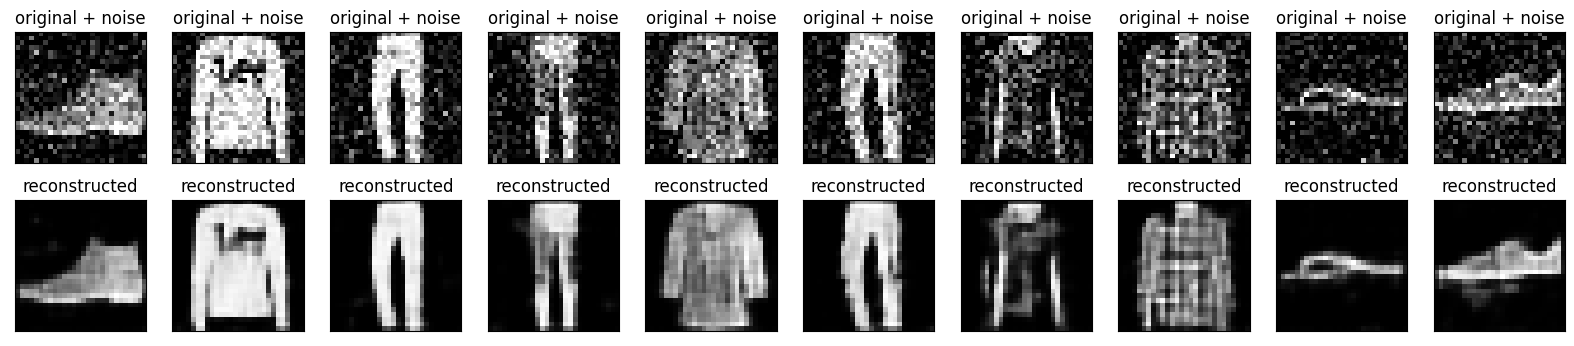

In [19]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

## 세 번째 예: 이상 감지

## 개요

이 예에서는 [ECG5000 데이터세트](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000)에서 이상을 감지하도록 autoencoder를 훈련합니다. 이 데이터세트에는 각각 140개의 데이터 포인트가 있는 5,000개의 [심전도](https://en.wikipedia.org/wiki/Electrocardiography)가 포함되어 있습니다. 단순화 된 버전의 데이터세트를 사용하고, 각 예제는 `0`(비정상 리듬에 해당) 또는 `1`(정상 리듬에 해당)으로 레이블이 지정됩니다. 여러분은 비정상 리듬을 식별하는 데 관심이 있습니다.

참고: 레이블이 지정된 데이터세트를 사용하므로 지도 학습 문제라고 표현할 수 있습니다. 이 예의 목표는 사용 가능한 레이블이 없는 더 큰 데이터세트에 적용할 수 있는 이상 감지 개념을 설명하는 것입니다(예: 정상 리듬이 수천 개이고 비정상 리듬이 적은 경우).

autoencoder를 사용하여 이상을 어떻게 감지하겠습니까? autoencoder는 재구성 오류를 최소화하도록 훈련되었습니다. autoencoder는 정상 리듬으로만 훈련한 다음 이 autoencoder를 사용하여 모든 데이터를 재구성합니다. 여기서 가설은 비정상 리듬의 경우에 재구성 오류가 더 클 것이라는 것입니다. 그런 다음 재구성 오류가 고정 임계값을 초과하는 경우, 리듬을 이상으로 분류합니다.

### ECG 데이터 로드하기

사용할 데이터세트는 [timeseriesclassification.com](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000)의 데이터세트를 기반으로 합니다.


In [20]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [21]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

데이터를 `[0,1]`로 정규화합니다.


In [22]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

이 데이터세트에서 `1`로 레이블이 지정된 정상 리듬만 사용하여 autoencoder를 훈련합니다. 정상 리듬과 비정상 리듬을 분리합니다.

In [23]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

정상적인 ECG를 플롯합니다. 

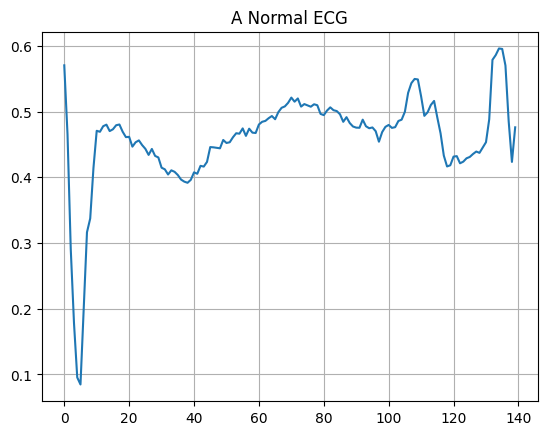

In [24]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

비정상적인 ECG를 플롯합니다.

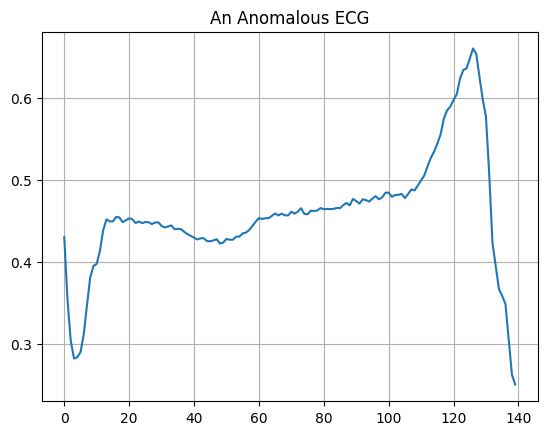

In [25]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

### 모델 빌드하기

In [26]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [27]:
autoencoder.compile(optimizer='adam', loss='mae')

autoencoder는 일반 ECG만 사용하여 훈련되지만, 전체 테스트세트를 사용하여 평가됩니다.

In [28]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=20, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20


1/5 [=====>........................] - ETA: 8s - loss: 0.0591

5/5 [==============================] - 2s 43ms/step - loss: 0.0578 - val_loss: 0.0533


Epoch 2/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0568

5/5 [==============================] - 0s 11ms/step - loss: 0.0558 - val_loss: 0.0518


Epoch 3/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0542

5/5 [==============================] - 0s 11ms/step - loss: 0.0534 - val_loss: 0.0504


Epoch 4/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0516

5/5 [==============================] - 0s 11ms/step - loss: 0.0504 - val_loss: 0.0487


Epoch 5/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0481

5/5 [==============================] - 0s 11ms/step - loss: 0.0470 - val_loss: 0.0470


Epoch 6/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0448

5/5 [==============================] - 0s 11ms/step - loss: 0.0437 - val_loss: 0.0451


Epoch 7/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0416

5/5 [==============================] - 0s 11ms/step - loss: 0.0403 - val_loss: 0.0432


Epoch 8/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0385

5/5 [==============================] - 0s 12ms/step - loss: 0.0372 - val_loss: 0.0415


Epoch 9/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0355

5/5 [==============================] - 0s 12ms/step - loss: 0.0345 - val_loss: 0.0403


Epoch 10/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0330

5/5 [==============================] - 0s 11ms/step - loss: 0.0322 - val_loss: 0.0392


Epoch 11/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0311

5/5 [==============================] - 0s 12ms/step - loss: 0.0303 - val_loss: 0.0384


Epoch 12/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0293

5/5 [==============================] - 0s 11ms/step - loss: 0.0286 - val_loss: 0.0374


Epoch 13/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0277

5/5 [==============================] - 0s 11ms/step - loss: 0.0272 - val_loss: 0.0364


Epoch 14/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0256

5/5 [==============================] - 0s 11ms/step - loss: 0.0259 - val_loss: 0.0359


Epoch 15/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0257

5/5 [==============================] - 0s 11ms/step - loss: 0.0248 - val_loss: 0.0353


Epoch 16/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0247

5/5 [==============================] - 0s 11ms/step - loss: 0.0239 - val_loss: 0.0347


Epoch 17/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0239

5/5 [==============================] - 0s 11ms/step - loss: 0.0233 - val_loss: 0.0344


Epoch 18/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0229

5/5 [==============================] - 0s 12ms/step - loss: 0.0228 - val_loss: 0.0339


Epoch 19/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0222

5/5 [==============================] - 0s 12ms/step - loss: 0.0223 - val_loss: 0.0335


Epoch 20/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0221

5/5 [==============================] - 0s 11ms/step - loss: 0.0218 - val_loss: 0.0332


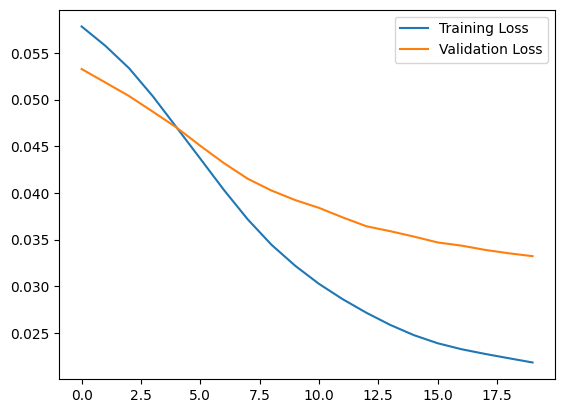

In [29]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

재구성 오류가 정상 훈련 예제에서 하나의 표준 편차보다 큰 경우, ECG를 비정상으로 분류합니다. 먼저, 훈련 세트의 정상 ECG, autoencoder에 의해 인코딩 및 디코딩된 후의 재구성, 재구성 오류를 플롯해 보겠습니다.

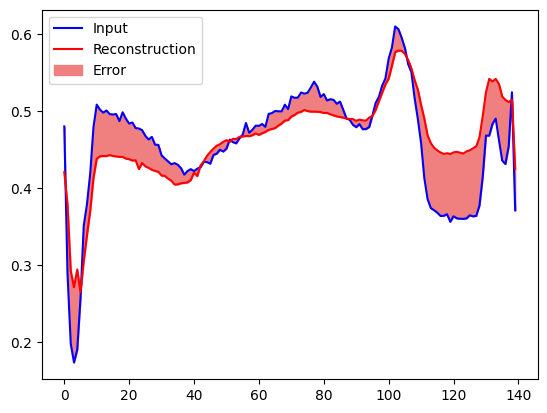

In [30]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

이번에는 비정상적인 테스트 예제에서 비슷한 플롯을 만듭니다.

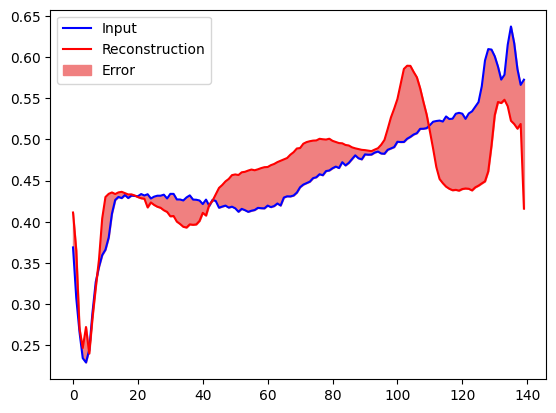

In [31]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### 이상 감지하기

재구성 손실이 고정 임계값보다 큰지 여부를 계산하여 이상을 감지합니다. 이 튜토리얼에서는 훈련 세트에서 정상 예제에 대한 평균 오차를 계산한 다음, 재구성 오류가 훈련 세트의 표준 편차보다 큰 경우 향후 예제를 비정상적인 것으로 분류합니다.


훈련 세트에서 정상 ECG에 대한 재구성 오류를 플롯합니다.

 1/74 [..............................] - ETA: 7s

37/74 [==============>...............] - ETA: 0s

74/74 [==============================] - ETA: 0s

74/74 [==============================] - 0s 1ms/step


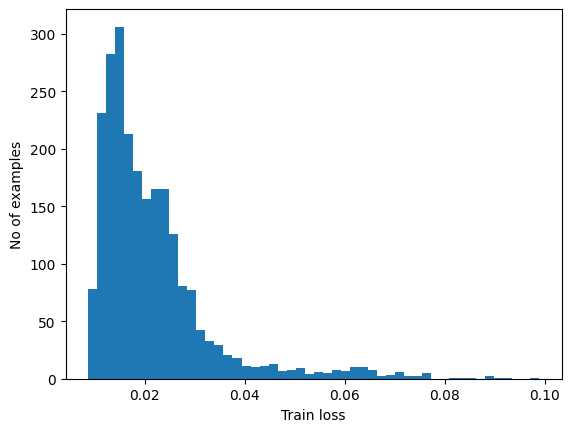

In [32]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

평균보다 표준 편차가 높은 임계값을 선택합니다.

In [33]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.033277668


참고: 테스트 예제를 이상 항목으로 분류하는 임계값을 선택하는 데 사용할 수 있는 다른 전략이 있습니다. 올바른 접근 방식은 데이터세트에 따라 다릅니다. 이 튜토리얼의 끝에 있는 링크를 통해 더 많은 것을 배울 수 있습니다. 

테스트 세트에서 비정상적인 예제에 대한 재구성 오류를 조사하면 대부분 임계값보다 더 큰 재구성 오류가 있음을 알 수 있습니다. 임계값을 변경하여 분류자의 [정밀도](https://developers.google.com/machine-learning/glossary#precision)와 [재현율](https://developers.google.com/machine-learning/glossary#recall)을 조정할 수 있습니다. 

 1/14 [=>............................] - ETA: 0s

14/14 [==============================] - 0s 2ms/step


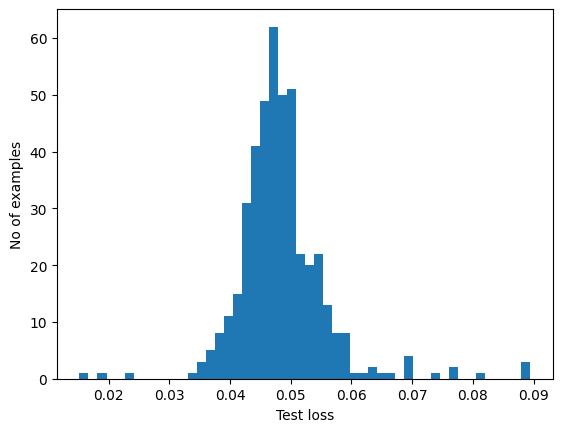

In [34]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

재구성 오류가 임계값보다 큰 경우 ECG를 이상으로 분류합니다.

In [35]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [36]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.944
Precision = 0.9941176470588236
Recall = 0.9053571428571429


## 다음 단계

autoencoder를 사용한 이상 탐지에 대해 자세히 알아보려면 Victor Dibia가 TensorFlow.js로 빌드한 훌륭한 [대화형 예제](https://anomagram.fastforwardlabs.com/#/)를 확인하세요. 실제 사용 사례의 경우, TensorFlow를 사용하여 [Airbus가 ISS 원격 측정 데이터에서 이상을 감지](https://blog.tensorflow.org/2020/04/how-airbus-detects-anomalies-iss-telemetry-data-tfx.html)하는 방법을 알아볼 수 있습니다. 기본 사항에 대해 자세히 알아보려면 François Chollet의 [블로그 게시물](https://blog.keras.io/building-autoencoders-in-keras.html)을 읽어보세요. 자세한 내용은 Ian Goodfellow, Yoshua Bengio, Aaron Courville의 [딥 러닝](https://www.deeplearningbook.org/)에서 14장을 확인하세요.
